In this notebook, we are analyzing the results of the CaseOLAP text mining association between 8 CVDs and protein groups representing cardiac proteins extracted from experimental dataset in 4 mammalian species (human, mouse, rat, pig).

Steps:
 1. Hierarchical clustering + PCA on results
 2. Calculate z-scores 
 3. Identify subproteomes w.r.t each CVD
     3.1 Violin plot
 4. Identify Protein Group Categories
 5. 

### Make a copy of the CaseOLAP text mining association results to this folder

In [1]:
! ls -lh ../caseolap/result/caseolap.csv
# ! mv ./caseolap.csv ./scratch/2022-05-03_caseolap.csv
! cp ../caseolap/result/caseolap.csv .

-rw-rw-r-- 1 ubuntu ubuntu 993K May 19 19:34 ../caseolap/result/caseolap.csv


In [2]:
# # also copy log file
# ! ls -lh ../cardiac_proteome_curation/combined_aliases.txt
# ! cp ../cardiac_proteome_curation/combined_aliases.txt .
# ! ls -lh ../caseolap/log/synonymcount_log.txt
# ! cp ../caseolap/log/synonymcount_log.txt .

! ls -lh ../caseolap/result/ranked_ent2syn2count.json 
! cp ../caseolap/result/ranked_ent2syn2count.json .

-rw-rw-r-- 1 ubuntu ubuntu 3.3M Jun 17 18:34 ../caseolap/result/ranked_ent2syn2count.json


In [3]:
! ls -lh

total 12M
-rw-rw-r-- 1 ubuntu ubuntu 2.4M Jul  7 00:19 '2022-05-19 Pathway Analysis Post Processing with dendrogram.ipynb'
-rw-rw-r-- 1 ubuntu ubuntu 1.9M Jul 11 22:59 '2022-07-06 Post Processing and Pathway Analysis .ipynb'
-rw-rw-r-- 1 ubuntu ubuntu 993K Jul 11 22:59  caseolap.csv
-rw-rw-r-- 1 ubuntu ubuntu  33K Jul  6 20:30  caseolap_zscore_violin_plot.pdf
-rw-rw-r-- 1 ubuntu ubuntu 2.3M Jun 16 21:06  combined_aliases.txt
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 25 23:26  output
-rw-rw-r-- 1 ubuntu ubuntu  34K Jul  7 00:05  pathways_unique_to_cvd_heatmap.pdf
-rw-rw-r-- 1 ubuntu ubuntu 3.3M Jul 11 22:59  ranked_ent2syn2count.json
drwxrwxr-x 2 ubuntu ubuntu 4.0K Jun 14 20:46  reactome_data
drwxrwxr-x 2 ubuntu ubuntu 4.0K May 25 22:54  reactome_results
drwxrwxr-x 2 ubuntu ubuntu 4.0K Jul  6 20:28  results
-rw-rw-r-- 1 ubuntu ubuntu 345K May 24 21:55  results.csv
drwxrwxr-x 3 ubuntu ubuntu 4.0K Jul  6 21:14  scratch
-rw-rw-r-- 1 ubuntu ubuntu 189K Jun 16 21:06  synonymcount_log.txt


In [4]:
! date

Mon Jul 11 22:59:47 UTC 2022


### Download latest Reactome data

In [5]:
! wget https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt
! wget https://reactome.org/download/current/ReactomePathwaysRelation.txt
! wget https://reactome.org/download/current/ReactomePathways.txt

! mv UniProt2Reactome_All_Levels.txt ./reactome_data
! mv ReactomePathwaysRelation.txt ./reactome_data
! mv ReactomePathways.txt ./reactome_data

--2022-07-11 22:59:47--  https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112995618 (108M) [text/plain]
Saving to: ‘UniProt2Reactome_All_Levels.txt’

UniProt2Reactome_Al 100%[===================>] 107.76M  23.2MB/s    in 5.1s    

2022-07-11 22:59:52 (21.2 MB/s) - ‘UniProt2Reactome_All_Levels.txt’ saved [112995618/112995618]

--2022-07-11 22:59:52--  https://reactome.org/download/current/ReactomePathwaysRelation.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587577 (574K) [text/plain]
Saving to: ‘ReactomePathwaysRelation.txt’

ReactomePathwaysRel 100%[===================>] 573.81K  1.79MB/s    in 0.3s    

2022-07-11 22:59:53 (1.79 MB/s) - ‘Rea

### Imports, input file paths, and notebook variables

In [6]:
# general
import os
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx


# stats
from sklearn import datasets # is this necessary?
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
from matplotlib.pyplot import figure
from matplotlib.tri import Triangulation
import seaborn as sns
from upsetplot import plot as upplot
%matplotlib inline

In [7]:
### input files ###
caseolap_results_file = "./caseolap.csv"
prot_to_uniref_file = '../cardiac_proteome_curation/human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv'
reactome_uniprot_to_pathway = "./reactome_data/UniProt2Reactome_All_Levels.txt"
reactome_hierarchy_to_pathway = "./reactome_data/ReactomePathwaysRelation.txt"
reactome_id_to_pathway_name = "./reactome_data/ReactomePathways.txt"

# synonym related files for redundancy removal
# alias_file = "./combined_aliases.txt"
# syn_count_file = "./synonymcount_log.txt"
## TODO remove the two above, replace with
entity_count_file = "../caseolap/result/ranked_ent2syn2count.json"

In [8]:
z_score_threshold = 3.0

In [9]:
def parse_uniref_to_uniprot_list(input_file, debug=False):
    # map uniref IDs back to proteins
    map_df = pd.read_csv(input_file, sep = "\t")
    map_df.columns = ['UniProt','UniRef90']
    uniref_to_uniprot_list = {}
    for upid, uniref_id in zip(map_df['UniProt'], map_df['UniRef90']):
        if uniref_id not in uniref_to_uniprot_list:
            uniref_to_uniprot_list[uniref_id] = []
        uniref_to_uniprot_list[uniref_id] += [upid]
    if debug:
        all_uniprot_ids = set()
        for ulist in uniref_to_uniprot_list.values():
            all_uniprot_ids = all_uniprot_ids.union(set(ulist))
        print("%d uniref ids and %d uniprot ids parsed"%(len(uniref_to_uniprot_list),
                                                        len(all_uniprot_ids)))
        
    return uniref_to_uniprot_list

uniref_to_uniprot_list = parse_uniref_to_uniprot_list(prot_to_uniref_file,debug=True)
uniref_to_uniprot_list

21732 uniref ids and 30571 uniprot ids parsed


{'UniRef90_P53621': ['P53621', 'G3V6T1', 'Q8CIE6', 'F8WHL2', 'F1RJX8'],
 'UniRef90_P22734': ['O88587', 'P22734'],
 'UniRef90_E7ETB4': ['E7ETB4'],
 'UniRef90_E1BEQ5': ['A0A286ZR74', 'F1STJ4', 'A0A286ZTR1'],
 'UniRef90_P50904': ['F1RP01', 'G3V9H0'],
 'UniRef90_D3ZZ37': ['D3ZZ37'],
 'UniRef90_Q61029': ['Q61029'],
 'UniRef90_A0A0C4DFQ9': ['C9JAV2'],
 'UniRef90_Q9R0M6': ['Q99P75', 'Q9R0M6', 'F1SRI1'],
 'UniRef90_P51114': ['C9JY20',
  'Q61584',
  'C9JZE0',
  'C9IZ22',
  'P51114',
  'I3LH62',
  'C9J5B4'],
 'UniRef90_Q920A5': ['Q920A5'],
 'UniRef90_Q5XHZ0': ['Q9CQN1', 'Q5XHZ0'],
 'UniRef90_Q9JMG1': ['Q9JMG1', 'P69736'],
 'UniRef90_O88384': ['O88384', 'P58200', 'F1LNC4'],
 'UniRef90_Q8WYL5': ['Q8WYL5'],
 'UniRef90_Q9WTP2': ['Q9WTP2'],
 'UniRef90_Q2HJ47': ['F1REW9', 'D3ZU54'],
 'UniRef90_A0A0B4J230': ['A0A0B4J230'],
 'UniRef90_Q6P996-2': ['Q86XE2'],
 'UniRef90_Q566Q7': ['Q566Q7'],
 'UniRef90_Q6QGC0': ['Q6QGC0'],
 'UniRef90_Q5XXA6': ['Q5XXA6'],
 'UniRef90_H3BV90': ['H3BV90'],
 'UniRef90_P21533': 

In [10]:
# load CaseOLAP scores
raw_caseolap_scores = pd.read_csv(caseolap_results_file)

In [11]:
raw_caseolap_scores

,protein,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
0,UniRef90_Q5SF07-2,0.000000,0.013978,0.000000,0.016263,0.000000,0.000000,0.000000,0.000000
1,UniRef90_S4R3U1,0.009267,0.009541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,UniRef90_F1SID7,0.022570,0.070068,0.032458,0.112651,0.032643,0.028304,0.011128,0.049038
3,UniRef90_D6RF25,0.032819,0.006016,0.000000,0.000000,0.006724,0.000000,0.000000,0.016352
4,UniRef90_F2Z393,0.000000,0.019085,0.000000,0.000000,0.000000,0.000000,0.000000,0.006329
...,...,...,...,...,...,...,...,...,...
10191,UniRef90_P07358,0.011694,0.000000,0.010709,0.000000,0.000000,0.000000,0.000000,0.000000
10192,UniRef90_H0YAN3,0.016419,0.013978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10193,UniRef90_A0A4X1UPC8,0.028182,0.016895,0.020277,0.011093,0.010658,0.000000,0.000000,0.018988
10194,UniRef90_Q5D144,0.028714,0.035924,0.026373,0.000000,0.000000,0.000000,0.000000,0.032553


## Combine Redundant ProteinGroups

In [12]:
import json
import pandas as pd

def prepare_ranked_ent(file_name):
    with open(file_name, 'r') as j:
        contents = json.loads(j.read())
        df = pd.DataFrame(contents)
        return df
    
ranked_ent_df = prepare_ranked_ent("../caseolap/result/ranked_ent2syn2count.json")

In [13]:
ranked_ent_df

,ARR,CCD,CHD,CM,IHD,OTH,TOTAL,VD,VOO
UniRef90_Q9JJV9,"{'SCN5A': 2924, 'Scn5a': 324}","{'SCN5A': 2360, 'Scn5a': 242}","{'SCN5A': 1001, 'Scn5a': 91}","{'SCN5A': 297, 'Scn5a': 34}","{'SCN5A': 71, 'Scn5a': 11}","{'SCN5A': 636, 'Scn5a': 20}","{'SCN5A': 3143, 'Scn5a': 340}",{'SCN5A': 29},{'SCN5A': 4}
UniRef90_Q14524,"{'SCN5A': 2924, 'hH1': 57}","{'SCN5A': 2360, 'hH1': 50}","{'SCN5A': 1001, 'hH1': 39}",{'SCN5A': 297},{'SCN5A': 71},"{'SCN5A': 636, 'hH1': 6}","{'SCN5A': 3143, 'hH1': 57}",{'SCN5A': 29},{'SCN5A': 4}
UniRef90_F1SJS9,"{'SCN5A': 2924, 'sodium channel protein': 16}","{'SCN5A': 2360, 'sodium channel protein': 12}","{'SCN5A': 1001, 'sodium channel protein': 5}","{'SCN5A': 297, 'sodium channel protein': 3}","{'SCN5A': 71, 'sodium channel protein': 1}","{'SCN5A': 636, 'sodium channel protein': 2}","{'SCN5A': 3143, 'sodium channel protein': 19}",{'SCN5A': 29},{'SCN5A': 4}
UniRef90_P51787,"{'KCNQ1': 2099, 'KVLQT1': 201, 'voltage-gated ...","{'KCNQ1': 1739, 'KVLQT1': 199, 'KCNA9': 1}","{'KCNQ1': 1691, 'KVLQT1': 197, 'KCNA9': 1}","{'KCNQ1': 61, 'KVLQT1': 3}",{'KCNQ1': 69},"{'KCNQ1': 268, 'KVLQT1': 21}","{'KCNQ1': 2190, 'KVLQT1': 203, 'voltage-gated ...","{'KCNQ1': 20, 'KVLQT1': 2}",{}
UniRef90_P97414,"{'KCNQ1': 2099, 'Kcnq1': 65, 'Kvlqt1': 5, 'vol...","{'KCNQ1': 1739, 'Kcnq1': 61, 'Kvlqt1': 5}","{'KCNQ1': 1691, 'Kcnq1': 61, 'Kvlqt1': 5}","{'KCNQ1': 61, 'Kcnq1': 1}","{'KCNQ1': 69, 'Kcnq1': 1}","{'KCNQ1': 268, 'Kcnq1': 4}","{'KCNQ1': 2190, 'Kcnq1': 66, 'Kvlqt1': 5, 'vol...",{'KCNQ1': 20},{}
...,...,...,...,...,...,...,...,...,...
UniRef90_M3XWI2,{},{},{},{'uracil-DNA glycosylase': 1},{},{},{'uracil-DNA glycosylase': 1},{},{}
UniRef90_Q13009,{},{},{},{},{'TIAM1': 1},{'TIAM1': 4},{'TIAM1': 6},{'TIAM1': 1},{}
UniRef90_F1RRJ4,{},{},{'XPO5': 2},{'XPO5': 1},{'XPO5': 4},{},{'XPO5': 7},{},{}
UniRef90_A0A1U7UBD0,{},{},"{'MTHFD2': 2, 'methenyltetrahydrofolate cycloh...",{},{},{},"{'MTHFD2': 2, 'methenyltetrahydrofolate cycloh...",{},{}


In [14]:
ranked_ent_df.astype(str).duplicated(keep='first')

UniRef90_Q9JJV9        False
UniRef90_Q14524        False
UniRef90_F1SJS9        False
UniRef90_P51787        False
UniRef90_P97414        False
                       ...  
UniRef90_M3XWI2         True
UniRef90_Q13009         True
UniRef90_F1RRJ4        False
UniRef90_A0A1U7UBD0    False
UniRef90_P07737        False
Length: 10196, dtype: bool

In [15]:
ranked_ent_df[ranked_ent_df['TOTAL'].str.contains("ACTR2", na=False)]

,ARR,CCD,CHD,CM,IHD,OTH,TOTAL,VD,VOO


In [16]:
for u,s in zip(ranked_ent_df.index,ranked_ent_df['TOTAL']):
    if "ACTR2" in str(s):
        print(u,s)

UniRef90_F5H6T1 {'ACTR2': 1}
UniRef90_P61160 {'actin-related protein 2': 1, 'ARP2': 1, 'ACTR2': 1}
UniRef90_A0A667XNM0 {'ACTR2': 1, 'actin-related protein 2': 1}
UniRef90_A0A1B0GWH0 {'ACTR2': 1, 'actin-related protein 2': 1}
UniRef90_A0A2K6TU91 {'ACTR2': 1}


In [17]:
def prepare_synonyms(ranked_ent_df):
    '''
    This function prepares the synonym column to be added to the summary table
    UniRef ID -> list of synonyms
    '''
    uniref_to_synonyms = {}
    for uniref in ranked_ent_df.index:
        all_synonyms_dict = ranked_ent_df.loc[uniref]['TOTAL']
        uniref_to_synonyms[uniref] = list(all_synonyms_dict.keys())
    return uniref_to_synonyms
        
new_id_to_synonym = prepare_synonyms(ranked_ent_df)


In [18]:
## TODO we don't need syn_count anymore!! Remove

# based off of Dylan's code
# source: http://34.217.174.15:8888/edit/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/caseolap/caseolap/_13_inspect_entity_scores.py

# note to kaitlyn, i didn't want to make a class or read his code, i just wrote this real quick, idk.
def read_synonym_count_log(file_name):
    syn_to_count = {}
    for l in [l.strip("\n") for l in open(file_name,"r").readlines()]:
        s = l.split("|")
        count = int(s[0].split(":")[1])
        syn = s[1]
        syn_to_count[syn] = count
    return syn_to_count


syn_count = read_synonym_count_log("../caseolap/log/synonymcount_log.txt")
syn_count

{'KCNQ1': 2190,
 'HMG14': 1,
 'DBI': 11,
 'GABPB2': 1,
 'type 1 inositol 1,4,5-trisphosphate receptor': 2,
 'B-CK': 9,
 'perlecan': 63,
 'plexin-B2': 2,
 'transcription factor 8': 1,
 'SEL1L': 1,
 'AKAP10': 8,
 'Slc27a1': 1,
 'php': 1,
 'Fatty acid-binding protein 4': 6,
 'Vasodilator-Stimulated Phosphoprotein': 6,
 'Glucocorticoid receptor': 9,
 'gt': 365,
 'Caspase-3': 382,
 'DDHD2': 1,
 'HSPA8': 10,
 'CD44': 247,
 'STXBP2': 3,
 'Ndufs4': 16,
 'Mef2d': 7,
 'phospholemman': 39,
 'Phospholipid transfer protein': 5,
 'mitogen-activated protein kinase kinase 4': 2,
 'Abcb8': 2,
 'regulator of cell cycle': 2,
 'ADP/ATP translocase': 7,
 'ARFGEF2': 10,
 'ST5': 4,
 'Trap1': 1,
 'MSK1': 8,
 'RTCA': 4,
 'OST': 25,
 'OTT': 8,
 'Coq7': 1,
 'Transcription factor GATA-4': 1,
 'TMEM173': 3,
 'PTPRG': 1,
 'Spermine synthase': 1,
 'COPZ2': 1,
 'GSAS': 4,
 'toll-like receptor 3': 3,
 'LEO1': 1,
 'NLN': 4,
 'sip': 1,
 'Tim14': 2,
 'Bcl-x': 18,
 'TAR DNA-binding protein 43': 1,
 'Dab2': 22,
 'APOC1': 1

In [19]:
## TODO we don't need uniref to synonyms anymore!! remove
#UniRef ID and a list of its synonyms

def uniRef_to_synonyms(file_name):
    id_to_synonym = {}
    for l in [l.strip("\n") for l in open(file_name,"r").readlines()]:
        s = l.split("|")
        if 'UniRef90' in s[0]:
            uniref_id = s[0]
            id_to_synonym[uniref_id] = s
        else:
            print('something wrong')
    return id_to_synonym
        
id_to_synonym = uniRef_to_synonyms('../cardiac_proteome_curation/combined_aliases.txt')
id_to_synonym

{'UniRef90_P53621': ['UniRef90_P53621',
  'F1RJX8_PIG',
  'Coatomer_subunit_alpha',
  'COPA'],
 'UniRef90_P22734': ['UniRef90_P22734',
  'COMT_RAT',
  'Catechol_O-methyltransferase',
  'Comt'],
 'UniRef90_E7ETB4': ['UniRef90_E7ETB4', 'E7ETB4_HUMAN', 'Clusterin', 'CLU'],
 'UniRef90_E1BEQ5': ['UniRef90_E1BEQ5',
  'A0A286ZTR1_PIG',
  'Angiomotin_like_1',
  'AMOTL1'],
 'UniRef90_P50904': ['UniRef90_P50904',
  'G3V9H0_RAT',
  'Ras_GTPase-activating_protein_1',
  'Rasa1'],
 'UniRef90_D3ZZ37': ['UniRef90_D3ZZ37',
  'D3ZZ37_RAT',
  'Mitochondrial_assembly_of_ribosomal_large_subunit_1',
  'Malsu1',
  'RGD1306936_predicted',
  'rCG_52366'],
 'UniRef90_Q61029': ['UniRef90_Q61029',
  'Q3UCI5',
  'Q61030',
  'Q61031',
  'Q61032',
  'LAP2B_MOUSE',
  'Lamina-associated_polypeptide_2,_isoforms_beta/delta/epsilon/gamma',
  'Thymopoietin_isoforms_beta/delta/epsilon/gamma',
  'Tmpo',
  'Lap2'],
 'UniRef90_A0A0C4DFQ9': ['UniRef90_A0A0C4DFQ9',
  'C9JAV2_HUMAN',
  'DCN1-like_protein',
  'Defective_in_cullin

In [20]:
'''
TODO:
- We have a new id_to_synonym now
- WE don't need syn_to_count anymore
- We don't need to filter synonyms anymore, since we have all synonyms > count 1
- remove brackets not necessary anymore?
'''
def uniRef_to_synonyms(file_name):
    id_to_synonym = {}
    for l in [l.strip("\n") for l in open(file_name,"r").readlines()]:
        s = l.split("|")
        if 'UniRef90' in s[0]:
            uniref_id = s[0]
            id_to_synonym[uniref_id] = s
        else:
            print('something wrong')
    return id_to_synonym

# Use


# based off of Dylan's code
# source: http://34.217.174.15:8888/edit/ALEXANDER-Projects/2021-04-26_Cardiac_Proteome/caseolap/caseolap/_13_inspect_entity_scores.py
def read_synonym_count_log(file_name):
    syn_to_count = {}
    for l in [l.strip("\n") for l in open(file_name,"r").readlines()]:
        s = l.split("|")
        count = int(s[0].split(":")[1])
        syn = s[1]
        syn_to_count[syn] = count
    return syn_to_count


#list of synonyms above count 0
def filter_synonyms(uniRef_list, syn_to_count, id_to_synonym):
    list_of_synonyms = []
    syns_above_count = set([syn for syn, count in syn_to_count.items() if count > 0]) 
    
    for uniRef_id in uniRef_list:
        synonyms = set(id_to_synonym[uniRef_id])
        list_of_synonyms.append(list(synonyms.intersection(syns_above_count)))        
        
    return list_of_synonyms

#removing brackets from the synonym list
def remove_brackets(syns):
    no_brackets = []
    
    for terms in syns:
        new_list = (', '.join(str(a)for a in terms))
        no_brackets.append(new_list)
                
    return no_brackets



#condolidates the summary_table by matching synonyms and caseOLAP scores
def merge_UniRefIDs(dataFrame, uniref_to_uniprot_list, combined_alias_file, synonym_count_file):
    '''
    #identify rows that are duplicate by matching synonyms and caseolap values
    #duplicate rows have their mapped proteins merged and their uniref IDs merged (separated by semicolon)
    #function merge_UniRef ID's
    '''
    
    # make map_df here
    map_df = ...
    
    uniRef_list = list(dataFrame.index)
    # load mapping from UniRef ID to synonyms
    id_to_synonym = uniRef_to_synonyms(combined_alias_file)
    # load file with frequency counts of synonyms
    syn_count = read_synonym_count_log(synonym_count_file)
    # obtaining the synonyms for each uniref
    syns = filter_synonyms(uniRef_list, syn_count, id_to_synonym) 
    # removing the brackets from this list of synonyms to make it look cleaner in the table
    no_bracket_syns = remove_brackets(syns)

    ### Formatting and adding columns ###
    #fixing title "protein" to "protein group" in summary_table
    dataFrame = dataFrame.rename_axis('protein group')
    # adds the mapped proteins to the table
    dataFrame = dataFrame.merge(map_df.set_index('UniRef90'), 
                                        right_index = True, left_index = True, how = 'left')

    # move the mapped proteins column to the front
    dataFrame.insert(0, 'Mapped Proteins', summary_table.pop('UniProt list'))

    #adding the Synonyms column to the table
    dataFrame.insert(1, 'Synonyms', no_bracket_syns)

    #new dataframe for the merged/nonredundant UniRefIDs
    merged_df = pd.DataFrame()
    
    #obtaining list of synonyms
    list_of_syns = dataFrame['Synonyms']

    #list of nonredundant synonyms
    no_duplicate_syns = set(list_of_syns)
    
    #obtaining list of CVDs
    CVDs = dataFrame.columns[2:10]

    ## TODO merge on synonyms AND scores
    #for every unique synonym
    for syn in no_duplicate_syns:

        #dataframe only with synonym of current interest
        current_syn = dataFrame.loc[dataFrame['Synonyms'] == syn]

        #separate IDs and proteins with semicolon
        delim = '; '

        #condsolidating all of the UniRef IDs for the current synonym
        uniRefs_for_syn = []
        uniRef_list = set(current_syn.index) #getting rid of duplicate UniRefs
        s = delim.join(uniRef_list)
        uniRefs_for_syn.append(s)

        #consolidating all of the Mapped Proteins for the current synonym
        mappedProteins_current_syn = []
        mappedProteins_list = current_syn['Mapped Proteins']
        p = delim.join(mappedProteins_list)
        mappedProteins_current_syn.append(p)
        
        for group in uniRefs_for_syn: #getting rid of brackets when IDs are printed
            uniRefs_for_syn = group
        
        for group in mappedProteins_current_syn: #getting rid of brackets when proteins are printed
            mappedProteins_current_syn = group
        
        #adding the data to the table
        add_score = {'Protein Groups': uniRefs_for_syn, 'Mapped Proteins': mappedProteins_current_syn, "Synonyms": syn}

        #adding in the caseOLAP scores
        for cvd in CVDs:
              
            cvd_score = current_syn[cvd].mean()
            add_score[cvd] = cvd_score
    
        merged_df = merged_df.append(add_score, ignore_index = True)
        
    return merged_df

# TODO two print statements: 1) shows how many rows in original CaseOLAP scores, 
# 2) shows how many rows in the merged df. (how many rows did we combine?)
df = merge_UniRefIDs(raw_caseolap_scores, map_df, alias_file, syn_count_file)


NameError: name 'map_df' is not defined

In [21]:
#creating map_df
#uniref_to_uniprot_list
map_df = pd.DataFrame([uniref_to_uniprot_list.keys(), ["; ".join(v) for v in uniref_to_uniprot_list.values()]]).T
map_df
map_df.columns = [ "Protein Groups", "Mapped Proteins"]
map_df.set_index("Protein Groups")

,Mapped Proteins
Protein Groups,
UniRef90_P53621,P53621; G3V6T1; Q8CIE6; F8WHL2; F1RJX8
UniRef90_P22734,O88587; P22734
UniRef90_E7ETB4,E7ETB4
UniRef90_E1BEQ5,A0A286ZR74; F1STJ4; A0A286ZTR1
UniRef90_P50904,F1RP01; G3V9H0
...,...
UniRef90_G1L969,A0A286ZYL7
UniRef90_A0A2I3HEX7,H3BU51
UniRef90_Q3YEC7,Q3YEC7


In [22]:
new_id_to_synonym

{'UniRef90_Q9JJV9': ['SCN5A', 'Scn5a'],
 'UniRef90_Q14524': ['SCN5A', 'hH1'],
 'UniRef90_F1SJS9': ['SCN5A', 'sodium channel protein'],
 'UniRef90_P51787': ['KCNQ1',
  'KVLQT1',
  'voltage-gated potassium channel subunit Kv7.1',
  'KCNA9'],
 'UniRef90_P97414': ['KCNQ1',
  'Kcnq1',
  'Kvlqt1',
  'voltage-gated potassium channel subunit Kv7.1'],
 'UniRef90_F1SAW8': ['CASQ2', 'calsequestrin', 'Calsequestrin'],
 'UniRef90_O00192': ['ARVC', 'ARVCF'],
 'UniRef90_P98203': ['ARVC'],
 'UniRef90_G3V226': ['calmodulin', 'Calmodulin', 'CALM1'],
 'UniRef90_O19062': ['C-reactive protein',
  'C-Reactive Protein',
  'C-Reactive protein',
  'C-reactive Protein'],
 'UniRef90_P48199': ['C-reactive protein',
  'C-Reactive Protein',
  'C-Reactive protein',
  'C-reactive Protein'],
 'UniRef90_A0A0G2K8V5': ['C-reactive protein',
  'C-Reactive Protein',
  'C-Reactive protein',
  'C-reactive Protein'],
 'UniRef90_P14847': ['C-reactive protein',
  'C-Reactive Protein',
  'C-Reactive protein',
  'C-reactive Prote

In [23]:
def merge_UniRefIDs(prot_to_UniRef, pg_to_syn, scores):
    
    #protein groups to synonym
    temp_sets = {k: set(v) for k,v in pg_to_syn.items()} #duplicate synonyms will be in same order
    temp = {k: ", ".join(v) for k,v in temp_sets.items()} #joining the synonyms
    pg_to_syn_df = pd.DataFrame.from_dict(temp, orient = 'index') #creating dataframe out of dict
    pg_to_syn_df.columns = ["Synonyms"]
    pg_to_syn_df.index.name = "Protein Groups"
       
    #creating the data frame with "Mapped Proteins" as index
    scores = scores.rename(columns = {"protein" : "Protein Groups"})
    scores = scores.set_index("Protein Groups")
    merged_df = scores.merge(pg_to_syn_df, right_index = True, left_index = True, how = 'left')
    merged_df = merged_df.merge(prot_to_UniRef.set_index('Protein Groups'), right_index = True, left_index = True, how = 'left')
    merged_df = merged_df.reset_index()
    merged_df = merged_df.set_index("Mapped Proteins")
    #return merged_df
   
    #creating a protein group to mapped proteins dictionary
    prot_to_pg_df = merged_df[['Protein Groups']]
    prot_to_pg_df = prot_to_pg_df.reset_index()
    prot_to_pg = {}
    for i in prot_to_pg_df['Mapped Proteins']:
        prot_to_pg[i] = [{prot_to_pg_df['Protein Groups'][j]} for j in prot_to_pg_df[prot_to_pg_df['Mapped Proteins']==i].index]
    
    #dataframe of just CVDs
    floats = merged_df.select_dtypes(include = ['float64'])
    integers = merged_df.select_dtypes(include = ['int64'])
    CVD_scores_df = pd.concat([floats, integers], axis = 1)
    
    #mapped proteins to synonym dictionary
    prot_to_syn_df = merged_df[['Synonyms']]
    prot_to_syn_df = prot_to_syn_df.reset_index()
    prot_to_syn = {}
    for i in prot_to_syn_df['Mapped Proteins']:
        prot_to_syn[i] = [{prot_to_syn_df['Synonyms'][j]} for j in prot_to_syn_df[prot_to_syn_df['Mapped Proteins']==i].index]

    #obtaining list of all synonyms
    all_syns = merged_df[['Synonyms']].values
    
    no_repeat_syns = []
    for i in all_syns:
        if i not in no_repeat_syns:
            no_repeat_syns.append(i)
    
    #for each synonym
    for syn in no_repeat_syns:
       
        for i in syn:
            syn = i

        #take a subset of that data frame - only those synonyms
        syn_df = merged_df.loc[merged_df['Synonyms'] == syn]

        #obtaining list of all mapped proteins in this subset
        all_mappedProteins = syn_df.index.to_list()    

        #obtaining list of all mapped proteins in reverse
        reverse_all_mappedProteins = [] 
        for i in all_mappedProteins:
             reverse_all_mappedProteins.insert(0,i)

        #these are the proteins that will be marked 'deleted' later on
        deleted_prots = []

        #starting at the beginning of the protein list
        for protein in all_mappedProteins:

            #delete protein from the reversed list so we don't match it against itself
            del reverse_all_mappedProteins[-1]

            #if this protein was not marked 'deleted', obtain its scores and synonyms
            if protein not in deleted_prots:

                #protein of focus' score 
                prot_score = CVD_scores_df.loc[protein].to_numpy()

                #protein of focus' synonym
                prot_synonym = prot_to_syn[protein] 

                #going through the synonyms
                all_mappedProteins_syns = []
                for entry in prot_synonym:
                    for synonym in entry:
                        single_syn = synonym.split(sep = ', ')
                        for syn in single_syn:
                            all_mappedProteins_syns.append(syn)
                all_mappedProteins_syns = set(all_mappedProteins_syns)

                #these will stores the UniRefs and mapped proteins to be appended
                UniRefs_to_append = []
                mappedProts_to_append = []

                #now to compared against another protein
                for other_protein in reverse_all_mappedProteins:  

                    #if this protein was not marked 'deleted', obtain its scores and synonyms as well
                    if other_protein != 'deleted':

                        #score of protein being compared
                        other_prot_score = CVD_scores_df.loc[other_protein].to_numpy()

                        #synonym of protein being compared
                        other_prot_syns = prot_to_syn[other_protein]

                        #going through the synonyms
                        all_other_syns = []
                        for entry in other_prot_syns:
                            for synonym in entry:
                                single_syn = synonym.split(sep = ', ')
                                for syn in single_syn:
                                    all_other_syns.append(syn)
                        all_other_syns = set(all_other_syns)

                        #if protein of focus and the one being compared match in score and synonym:
                        if (all_other_syns == all_mappedProteins_syns) and (np.array_equal(prot_score, other_prot_score, equal_nan=True)):

                            #other_protein and its UniRef need to be appended
                            mappedProts_to_append.append(other_protein)

                            pg = prot_to_pg[other_protein]
                            for group in pg: 
                                if group not in UniRefs_to_append:
                                    UniRefs_to_append.append(group)

                            #marked other_protein from original and reversed list as 'deleted'
                            deleted_prots.append(other_protein)
                            reverse_all_mappedProteins = [i.replace(other_protein, 'deleted') for i in reverse_all_mappedProteins]

                            #removing other_protein entry in df
                            merged_df = merged_df.drop(index = other_protein) 

                #append other UniRefs and mapped proteins to same entry as protein of focus
                mappedProts_to_append.append(protein)

                current_UniRef = prot_to_pg[protein]        

                for group in current_UniRef:
                    if group not in UniRefs_to_append:
                        UniRefs_to_append.append(current_UniRef)

                mappedProts_to_append = str(mappedProts_to_append)
                UniRefs_to_append = str(UniRefs_to_append)
                protein = str(protein)

                merged_df.loc[[protein], ["Protein Groups"]] = UniRefs_to_append

                merged_df = merged_df.rename(index={protein: mappedProts_to_append})
                    
        
    pd.set_option("display.max_colwidth", None)

    #setting the index back to protein groups
    merged_df = merged_df.reset_index()
    merged_df = merged_df.set_index('Protein Groups') 
    
    syns_column = merged_df.pop('Synonyms')
    merged_df.insert(1, 'Synonyms', syns_column)
    
    new_index = []
    for i in merged_df.index:
        i_temp = "; ".join(i.replace("[","").replace("]","").replace("{","").replace("}","").replace("'","").split(", "))
        new_index += [i_temp]
    merged_df.index = new_index
    
    new_mapped_proteins = []
    for i in merged_df['Mapped Proteins']:
        i_temp = "; ".join(i.replace("[","").replace("]","").replace("'","").replace(";",",").split(", "))
        new_mapped_proteins += [i_temp]
    merged_df['Mapped Proteins'] = new_mapped_proteins
    
    merged_df = merged_df.rename_axis("Protein Groups")
    
    return merged_df

merged = merge_UniRefIDs(map_df, new_id_to_synonym, raw_caseolap_scores)
merged   

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,F8W930; Q9Y6M1; F1SFK0,IGF2BP2,0.000000,0.013978,0.000000,0.016263,0.000000,0.000000,0.000000,0.000000
UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,B1AUU8; P42566; S4R3U1,epidermal growth factor receptor substrate 15,0.009267,0.009541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
UniRef90_F1SID7,F1SID7,"Myosin Binding Protein C3, MYBPC3, myosin binding protein C3, Myosin binding protein C3",0.022570,0.070068,0.032458,0.112651,0.032643,0.028304,0.011128,0.049038
UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,A0A0A0MSR2; E7EV99; D6RJE2; H0YG19; P35611; E7ENY0; H0Y9H2; D6RAH3; D6RF25,"alpha-Adducin, ADD1, alpha-adducin, Alpha-adducin",0.032819,0.006016,0.000000,0.000000,0.006724,0.000000,0.000000,0.016352
UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,E9PKI8; E9PM01; F2Z393,"TALDO1, transaldolase",0.000000,0.019085,0.000000,0.000000,0.000000,0.000000,0.000000,0.006329
...,...,...,...,...,...,...,...,...,...,...
UniRef90_Q92905,Q92905,CSN5,0.011694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021902
UniRef90_Q07076,Q07076; A0A5G2R850; P20073,"annexin A7, Annexin A7",0.005845,0.012036,0.023380,0.007000,0.006726,0.025547,0.007997,0.014692
UniRef90_P01344,P01344,"insulin-like growth factor II, Insulin-like growth factor II, IGF2",0.025691,0.027248,0.017449,0.019648,0.030951,0.014739,0.012662,0.026890


In [24]:
print("Number of merged protein groups before merging: %d"%raw_caseolap_scores.shape[0])
print("Number of merged protein groups after merging by synonyms: %d"%merged.shape[0])
print("%f%% of original number"%(100*merged.shape[0]/raw_caseolap_scores.shape[0]))

Number of merged protein groups before merging: 10196
Number of merged protein groups after merging by synonyms: 5634
55.256964% of original number


In [25]:
df = merged.copy(deep=True).reset_index().drop(["Mapped Proteins","Synonyms"],axis=1).rename(columns={'Protein Groups':'protein'})
# df = df.reset_index()
df.head()
# df['protein'] = 

,protein,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
0,UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,0.000000,0.013978,0.000000,0.016263,0.000000,0.000000,0.000000,0.000000
1,UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,0.009267,0.009541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,UniRef90_F1SID7,0.022570,0.070068,0.032458,0.112651,0.032643,0.028304,0.011128,0.049038
3,UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,0.032819,0.006016,0.000000,0.000000,0.006724,0.000000,0.000000,0.016352
4,UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,0.000000,0.019085,0.000000,0.000000,0.000000,0.000000,0.000000,0.006329


# Hierarchical clustering + PCA on results

In [26]:
# print(df.shape)
print("%d unique UniRef IDs associated with at least one CVD"%(df.shape[0]))
print("%d protein-disease relationships (including 0's)"%(df.shape[0]*df.shape[1]))
print("%d nonzero protein-disease relationships" %(np.count_nonzero(df,axis=None)))
print("%d zero protein-disease relationships" %(df.shape[0]*df.shape[1] - np.count_nonzero(df,axis=None)))

# all cardiovascular disease types
cvds = list(df.columns)[1:]

# make a boolean (True/False) table from original data
df_bool = df.copy()
for col in cvds:
    df_bool[col] = df[col] > 0

# get only rows with all true

all_true_df_bool = df_bool[df_bool[cvds].T.all()]
unirefs_in_all = set(all_true_df_bool['protein'])
print("%d UniRef90 IDs were found in all %s CVDs"%(len(unirefs_in_all),len(cvds)))

5634 unique UniRef IDs associated with at least one CVD
50706 protein-disease relationships (including 0's)
23514 nonzero protein-disease relationships
27192 zero protein-disease relationships
335 UniRef90 IDs were found in all 8 CVDs


In [27]:
# how many proteins does this correspond to?
uniprot_in_all = set()
num_uniref = 0
for uniref_ids in df['protein']:
    for uniref_id in uniref_ids.split("; "):
        proteins = set(uniref_to_uniprot_list[uniref_id])
#     print(proteins)
        uniprot_in_all = uniprot_in_all.union(proteins)
        num_uniref += 1
print("%d proteins associated to %d uniref IDs"%(len(uniprot_in_all),num_uniref))

14445 proteins associated to 10196 uniref IDs


In [28]:
for cvd in cvds:
    max_val = np.max(df[cvd])
    max_idx = df[cvd].idxmax()
    prot_group = df.iloc[max_idx]['protein']
    print(cvd, max_val,prot_group)


IHD 0.1848355183274148 UniRef90_H0YJG0; UniRef90_F8WCN3; UniRef90_A0A0G2JVQ1; UniRef90_H0YJK0; UniRef90_G3V461; UniRef90_P12532
CM 0.1246838019521497 UniRef90_P12821
ARR 0.149743284245183 UniRef90_Q9JJV9
VD 0.112651017146739 UniRef90_F1SID7
CHD 0.1700053877735026 UniRef90_Q61554
CCD 0.2064580317876307 UniRef90_Q9JJV9
VOO 0.0975191002285604 UniRef90_E7EN65; UniRef90_P15502; UniRef90_B3KRT8; UniRef90_Q99372; UniRef90_G5E950
OTH 0.0918753123764784 UniRef90_Q8R0I0


It is interesting that ARR and CCD have the same protein: Sodium Channel Protein Type 5 Subunit Alpha

In [ ]:
merged[merged.index == "UniRef90_Q8R0I0"]

In [ ]:
merged[merged.index == "UniRef90_P12821"]

IHD:
The UniRef90 IDs UniRef90_H0YJG0; UniRef90_F8WCN3; UniRef90_A0A0G2JVQ1; UniRef90_H0YJK0; UniRef90_G3V461; UniRef90_P12532 correspond to the proteins H0YJG0; F8WCN3; A0A0G2JVQ1; H0YJK0; G3V461; F1SI77 which is Creatine Kinase. 

CM:
The UniRef90 ID UniRef90_P12821 corresponds to the protein P12821 which is Angiotensin-Converting Enzyme.

ARR:
The UniRef90 ID UniRef90_Q9JJV9 corresponds to the proteins A0A0R4J1M7; Q9JJV9; F1LNF5; P15389 which is Sodium Channel Protein Type 5 Subunit Alpha.

VD:
The UniRef90 ID UniRef90_F1SID7 corresponds to the protein F1SID7 which is Myosin Binding Protein C3.

CHD:
The UniRef90 ID UniRef90_Q61554 corresponds to the protein Q61554 Fibrillin-1.

CCD:
The UniRef90 ID UniRef90_Q9JJV9 corresponds to the proteins A0A0R4J1M7; Q9JJV9; F1LNF5; P15389 which is Sodium Channel Protein Type 5 Subunit Alpha. Note: this is the same for ARR. 

VOO:
The UniRef90 IDs UniRef90_E7EN65; UniRef90_P15502; UniRef90_B3KRT8; UniRef90_Q99372; UniRef90_G5E950 correspond to the proteins E7EN65; E7ENM0; P15502; B3KRT8; P54320; A0A0G2JST5; G5E950 which is Elastin. 

OTH:
The UniRef90 ID UniRef90_Q8R0I0 corresponds to the protein D3ZYK4 which is Angiotensin-Converting Enzyme according to the 'merged' data frame. This is the same as CM but the UniRef ID is different. However, I checked and the protein ID D3ZYK4 is actually obselete in UniProt.


          IHD        CM       ARR        VD       CHD       CCD       VOO  \
2    0.022570  0.070068  0.032458  0.112651  0.032643  0.028304  0.011128   
64   0.079643  0.060707  0.041582  0.031714  0.028085  0.023884  0.024910   
75   0.040460  0.081827  0.040848  0.035847  0.035271  0.032445  0.020741   
86   0.184831  0.083380  0.059336  0.039728  0.032328  0.046295  0.035747   
132  0.142662  0.080923  0.058590  0.060233  0.038438  0.042852  0.037615   

          OTH  
2    0.049038  
64   0.040419  
75   0.071049  
86   0.050580  
132  0.063411  
(134, 8)
0.2064580317876307


/tmp/ipykernel_21843/1647319889.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


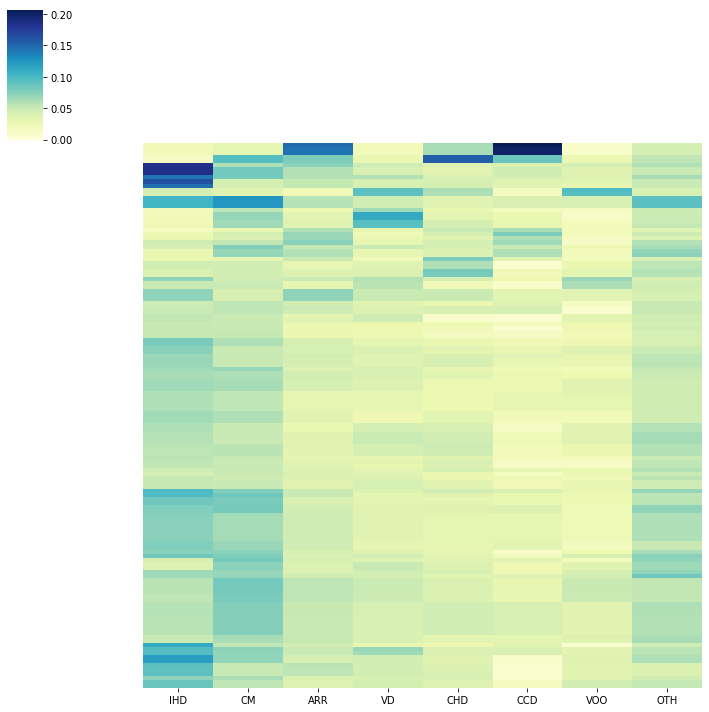

In [29]:
# heatmap visualizing the caseolap scores

def make_caseolap_score_heatmap(data, score_cutoff=0.05,
                    out_file = "./output/CaseOLAP_score_heatmap.pdf"):
    '''
    Makes a heatmap with caseolap scores. Only shows rows with at least one 
    score above score_cutoff
    '''    

    # remove protein column
    data = data.copy()
    data = data.drop(['protein'],axis=1)
    # only take those with at least one score above score_cutoff
    data = data[( data > score_cutoff).sum(axis=1) > 1]
    max_score = data.to_numpy().max()
    print(data.head())
    print(data.shape)
    print(max_score)
    # plot the heamap
    chart = sns.clustermap(data, cmap='YlGnBu', xticklabels=True, 
                                            yticklabels=False,col_cluster=False,row_cluster=True,
                                            vmin = 0.0, vmax=max_score, method='average',
                                            cbar_kws={"shrink": .5})
    #chart_axis = chart.ax_row_dendrogram.axes
    chart.ax_row_dendrogram.set_visible(False)

    # make it save/display in high-resolution
    fig = chart.fig
    fig.set_size_inches(10,10)

    # colorbar
    # fig.colorbar(ax.get_children()[0], orientation="horizontal")

    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,box_inches = 'tight')
    
    return chart
    
sub_df = df[df['protein'].isin(unirefs_in_all)]
make_caseolap_score_heatmap(sub_df)

explained variance
[0.63784497 0.11485142]
singular values
[2.14661795 0.91088882]


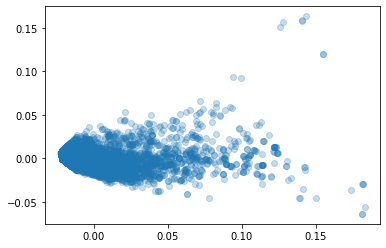

In [30]:
# pca for the caseolap scores

def make_caseolap_pca(data, out_file='./output/CaseOLAP_pca.pdf'):

    # remove protein column
    data = data.copy()
    data = data.drop(['protein'],axis=1)

    # compute pca
    pca = PCA(n_components=2)
    pca.fit(data)
    print("explained variance")
    print(pca.explained_variance_ratio_)
    print("singular values")
    print(pca.singular_values_)

    X_transformed = pca.transform(data)

    Xax=X_transformed[:,0]
    Yax=X_transformed[:,1]
    plt.scatter(Xax,Yax, alpha=0.25)
    
make_caseolap_pca(df)

Similarities among CVDs, as presented here, represent their conceptual similarities as determined by each CVD’s associations with specific protein groups. In brief, similar vectors in this plot represent diseases with similar protein involvement as per the literature.



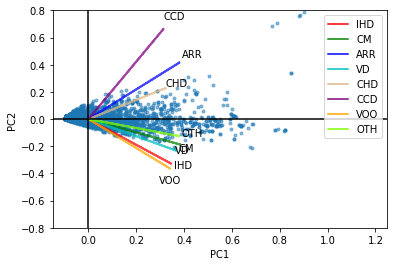

/tmp/ipykernel_21843/1637705448.py:79: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


In [31]:
# source: https://github.com/pinglab-intern/Textmining_caseOLAP
def pca_two(data, out_file='./output/CaseOLAP_pca.pdf'):

    # remove protein column
    data = data.copy()
    data = data.drop(['protein'],axis=1)
    # scale data
    scaler = StandardScaler()
    scaler.fit(data)
    X=scaler.transform(data)

    pca = PCA()
    pca.fit(X)
    X_transformed = pca.transform(X)     

    legend_elements = [Line2D([0], [0], color='r', label='IHD'),
                                     Line2D([0], [0], color='g', label='CM'),
                                     Line2D([0], [0], color='b', label='ARR'),
                                     Line2D([0], [0], color='c', label='VD'),
                                     Line2D([0], [0], color='burlywood', label='CHD'),
                                     Line2D([0], [0], color='purple', label='CCD'),
                                     Line2D([0], [0], color='orange', label='VOO'),
                                     Line2D([0], [0], color='chartreuse', label='OTH'),
                                     ]
    fig, ax = plt.subplots()

    ax.legend(handles=legend_elements, loc='upper right')
    #Call the function. Use only the 2 PCs.
    score = X_transformed[:,0:2]
    coeff = np.transpose(pca.components_[0:2, :])
    
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs*scalex ,ys*scaley, marker = '.', alpha = 0.5)
    plt.grid()
    
    #plot all the arrows along with catagory names
    IHD_arrow = plt.arrow(0, 0, coeff[0,0], coeff[0,1], color = 'r', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2, label = 'IHD')
    plt.text(coeff[0,0]* 1.15, coeff[0,1] * 1.15, "IHD", color = 'k', ha = 'center', va = 'bottom')

    plt.arrow(0, 0, coeff[1,0], coeff[1,1], color = 'g', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2)
    plt.text(coeff[1,0]* 1.15, coeff[1,1] * 1.15, "CM", color = 'k', ha = 'right', va = 'center')

    plt.arrow(0, 0, coeff[2,0], coeff[2,1], color = 'b', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2)
    plt.text(coeff[2,0]* 1.15, coeff[2,1] * 1.15, "ARR", color = 'k', ha = 'center', va = 'center')

    plt.arrow(0, 0, coeff[3,0], coeff[3,1], color = 'c', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2)
    plt.text(coeff[3,0]* 1.15, coeff[3,1] * 1.15, "VD", color = 'k', ha = 'right', va = 'bottom')

    plt.arrow(0, 0, coeff[4,0], coeff[4,1], color = 'burlywood', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2)
    plt.text(coeff[4,0]* 1.15, coeff[4,1] * 1.15, "CHD", color = 'k', ha = 'center', va = 'center')

    plt.arrow(0, 0, coeff[5,0], coeff[5,1], color = 'purple', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2)
    plt.text(coeff[5,0]* 1.15, coeff[5,1] * 1.15, "CCD", color = 'k', ha = 'center', va = 'center')

    plt.arrow(0, 0, coeff[6,0], coeff[6,1], color = 'orange', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2)
    plt.text(coeff[6,0]* 1.15, coeff[6,1] * 1.15, "VOO", color = 'k', ha = 'right', va = 'top')

    plt.arrow(0, 0, coeff[7,0], coeff[7,1], color = 'chartreuse', alpha = 0.7,linestyle = '-',linewidth = 2, overhang=0.2)
    plt.text(coeff[7,0]* 1.15, coeff[7,1] * 1.15, "OTH", color = 'k', ha = 'center', va = 'bottom')

    plt.xlim(-0.15,1.25)
    plt.ylim(-0.8,0.8)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    
    plt.grid()
    plt.axhline(y=0, color="black", linestyle="-")
    plt.axvline(x=0, color="black")
    plt.show()


    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,box_inches = 'tight')

pca_two(df)

# Calculate z-score

In [32]:
def convert_to_zscore(original_df, include_zeros = False, columns_to_ignore=['protein']):

    # make a copy of original, drop unnecessary columns
    new_df = original_df.copy().drop(columns_to_ignore, axis=1)
    temp_headers = new_df.columns

    # mask zeros if needed
    if not include_zeros:
        new_df[new_df == 0] = np.nan

    # convert to z-score
    zscore_values = zscore( new_df, axis = 0, ddof = 6, nan_policy = 'omit')
    
    # convert back to dataframe
    new_df = pd.DataFrame(zscore_values)
    new_df.columns = temp_headers
    # add dropped columns and return in same column ordering
    new_df = new_df.join(df[columns_to_ignore])
    new_df = new_df[original_df.columns]

    return new_df

# df is the original CaseOLAP scores matrix.
zscores_df = convert_to_zscore(df, include_zeros = False)
zscores_df=zscores_df.set_index('protein')
zscores_df.head()

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
protein,,,,,,,,
UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,NaN,-0.452814,NaN,-0.214451,NaN,NaN,NaN,NaN
UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,-0.716237,-0.766327,NaN,NaN,NaN,NaN,NaN,NaN
UniRef90_F1SID7,0.108814,3.511124,0.922885,7.245177,1.098519,0.492113,-0.708644,2.179526
UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,0.744491,-1.015490,NaN,NaN,-0.827632,NaN,NaN,-0.318468
UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,NaN,-0.091859,NaN,NaN,NaN,NaN,NaN,-1.084512


In [33]:
zscores_df.to_csv("./results/merged_caseolap_zscores.csv",index=True)

# 3. Identifying Protein Groups of interest


In [34]:
#reading the csv file
summary_table = pd.read_csv("./results/merged_caseolap_zscores.csv")
summary_table = summary_table.set_index('protein') 

#obtaining list of CVDs
CVDs = list(summary_table.columns)
print(CVDs)
summary_table.head()

['IHD', 'CM', 'ARR', 'VD', 'CHD', 'CCD', 'VOO', 'OTH']


,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
protein,,,,,,,,
UniRef90_Q9Y6M1; UniRef90_Q5SF07-2,NaN,-0.452814,NaN,-0.214451,NaN,NaN,NaN,NaN
UniRef90_A0A2K6R5I6; UniRef90_P42566; UniRef90_S4R3U1,-0.716237,-0.766327,NaN,NaN,NaN,NaN,NaN,NaN
UniRef90_F1SID7,0.108814,3.511124,0.922885,7.245177,1.098519,0.492113,-0.708644,2.179526
UniRef90_Q96D30; UniRef90_E7EV99; UniRef90_D6RJE2; UniRef90_H0YG19; UniRef90_P35611; UniRef90_H0Y9H2; UniRef90_G3I0J3; UniRef90_D6RF25,0.744491,-1.015490,NaN,NaN,-0.827632,NaN,NaN,-0.318468
UniRef90_E9PKI8; UniRef90_E9PM01; UniRef90_F2Z393,NaN,-0.091859,NaN,NaN,NaN,NaN,NaN,-1.084512


TODO: 
* change CVDs = list(summary_table.columns)
* add in synonyms and mapped proteins to the zscores_df BEFORE saving the file; rename 'protein' to 'Protein Group'

## 3.1 Identify Subproteomes w.r.t each CVD

In [35]:
#Sub-proteomes: Proteins with z-score above the threshold

sub_proteome_headers = []
for cvd in CVDs:
    cvd_sub = cvd + " Sub-proteome"
    summary_table[cvd_sub] = summary_table[cvd] >= z_score_threshold
    sub_proteome_headers += [cvd_sub]

summary_table[sub_proteome_headers].sort_values(sub_proteome_headers[0],ascending=False).head()

,IHD Sub-proteome,CM Sub-proteome,ARR Sub-proteome,VD Sub-proteome,CHD Sub-proteome,CCD Sub-proteome,VOO Sub-proteome,OTH Sub-proteome
protein,,,,,,,,
UniRef90_Q19AZ8; UniRef90_P19221,True,False,True,False,False,False,False,False
UniRef90_F1LMV8,True,True,False,False,False,False,False,True
UniRef90_P04040; UniRef90_P04762,True,True,False,False,False,False,False,False
UniRef90_Q8BWW9,True,True,False,False,False,False,False,True
UniRef90_P42227; UniRef90_P40763,True,True,False,False,False,False,False,True


In [36]:
# extract the z-scores of protein groups in the subproteome for each CVD
cvd_subproteome_to_scores = {}
for cvd in CVDs:
    
    # extract protein groups in subproteome
    tag = cvd+' Sub-proteome'
    proteins_in_subproteome = summary_table[summary_table[tag]].index
    print(tag,len(proteins_in_subproteome))
    
    # extract z-scores
    scores = list(summary_table[summary_table.index.isin(proteins_in_subproteome)][cvd])
    cvd_subproteome_to_scores[cvd] = scores

IHD Sub-proteome 55
CM Sub-proteome 65
ARR Sub-proteome 19
VD Sub-proteome 17
CHD Sub-proteome 35
CCD Sub-proteome 12
VOO Sub-proteome 5
OTH Sub-proteome 34


### Figure X. z-score distribution and Sub-proteome Violin Plot

In [37]:
# prepare plot values above threshold line
subproteome_plot_values = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in cvd_subproteome_to_scores.items() ]))

# gather counts for figure
cvd_to_sig_count = {}
cvd_to_x = {}
for cvd in subproteome_plot_values.columns:
    sig_ps = list(subproteome_plot_values[~subproteome_plot_values[cvd].isna()][cvd])
    cvd_to_sig_count[cvd] = len(sig_ps)
    cvd_to_x[cvd] = len(cvd_to_x)

# print(cvd_to_sig_count)
# print(cvd_to_x)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[Text(0, 0, 'IHD'),
 Text(1, 0, 'CM'),
 Text(2, 0, 'ARR'),
 Text(3, 0, 'VD'),
 Text(4, 0, 'CHD'),
 Text(5, 0, 'CCD'),
 Text(6, 0, 'VOO'),
 Text(7, 0, 'OTH')]

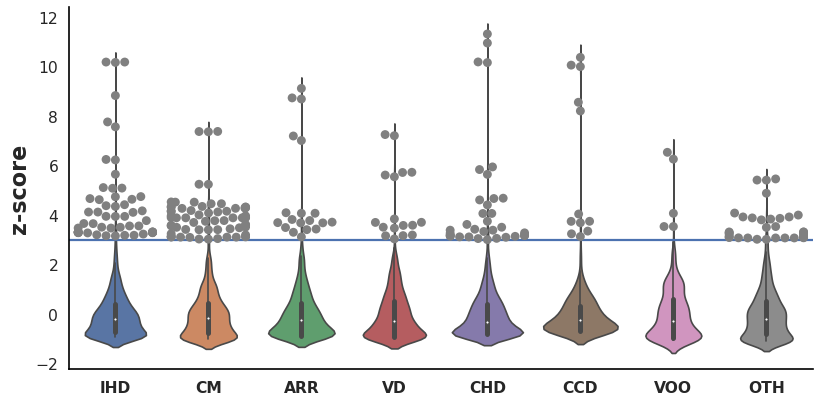

In [38]:
sns.set_theme(style="darkgrid")
figure(figsize=(12, 6), dpi=80)

# plot our data
ax = sns.violinplot(data=zscores_df)
sns.swarmplot( data=subproteome_plot_values, color="gray", edgecolor="white", size=8)
plt.plot([7.5, -0.5], [3, 3], linewidth=2)

# formatting
ax.set_facecolor('white')
# ax.set_title(plot_title, fontsize = 20)
ax.tick_params(axis='both', labelsize=14)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(axis='y', alpha=0.75)
# ax.set_xlabel(x_axis_text, fontsize = 20)
y_axis_text = "z-score"
ax.set_ylabel(y_axis_text, fontsize = 20, weight='bold')
ax.set_xticklabels(ax.get_xmajorticklabels(), weight='bold')
#ax.set_yticklabels(ax.get_ymajorticklabels(), weight='bold')

# plt.close()

[Text(0, -4.0, '−4'), Text(0, -2.0, '−2'), Text(0, 0.0, '0'), Text(0, 2.0, '2'), Text(0, 4.0, '4'), Text(0, 6.0, '6'), Text(0, 8.0, '8'), Text(0, 10.0, '10'), Text(0, 12.0, '12'), Text(0, 14.0, '14')]
[Text(0, -4.0, '-4.0'), Text(0, -2.0, '-2.0'), Text(0, 0.0, '0.0'), Text(0, 2.0, '2.0'), Text(0, 4.0, '4.0'), Text(0, 6.0, '6.0'), Text(0, 8.0, '8.0'), Text(0, 10.0, '10.0'), Text(0, 12.0, '12.0'), Text(0, 14.0, '14.0')]


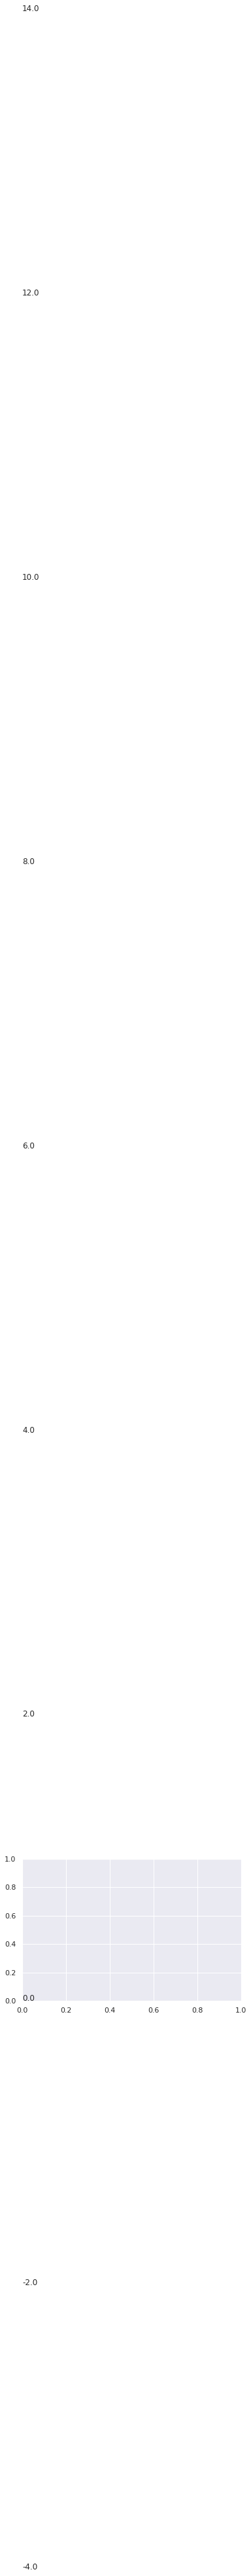

In [39]:
# for some reason the y_tick will NOT bold no matter what i try... doing this the dumb way
from matplotlib.pyplot import text
new_yticks = []
print(list(ax.get_ymajorticklabels()))
for y_ in list(ax.get_ymajorticklabels()):
    # print(y_.get_position())
    # print(y_.get_label())
    px,py = y_.get_position()
    tx = str(py)
    new_y_ = text(px,py,tx)
    new_yticks += [new_y_]
#     plt.close()
print(new_yticks)

# Now re-run the cell below

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipykernel_21843/4106997166.py:38: UserWarning: FixedFormatter shoul

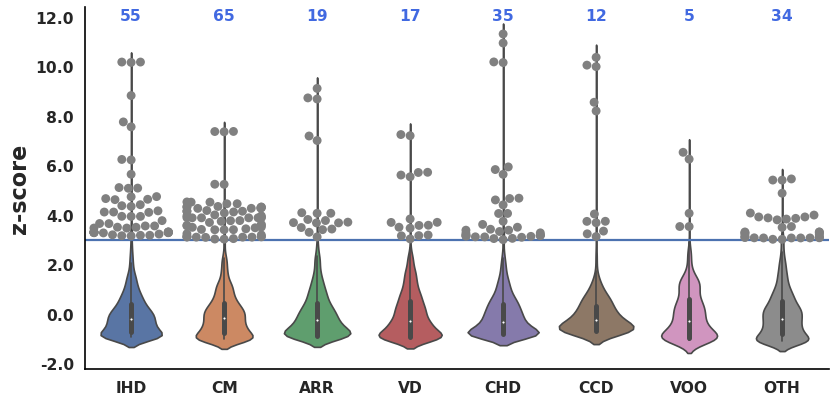

In [40]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

sns.set_theme(style="darkgrid")
figure(figsize=(12, 6), dpi=80)

# plot our data
ax = sns.violinplot(data=zscores_df)
sns.swarmplot( data=subproteome_plot_values, color="gray", edgecolor="white", size=8)
plt.plot([7.5, -0.5], [3, 3], linewidth=2)

# plot count above violin plot
max_y = max(list(subproteome_plot_values.max()))
text_height = max_y+0.75
for cvd, x_ind in cvd_to_x.items():
    pcount = cvd_to_sig_count[cvd]
    # plot text
    plt.text(x_ind,text_height,str(pcount),
            {'weight':'bold', 'fontsize':14, 'color':'royalblue'},
            ha='center', va='center')

# formatting
ax.set_facecolor('white')
# ax.set_title(plot_title, fontsize = 20)
ax.tick_params(axis='both', labelsize=14)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(axis='y', alpha=0.75)
# ax.set_xlabel(x_axis_text, fontsize = 20)
y_axis_text = "z-score"
ax.set_ylabel(y_axis_text, fontsize = 20, weight='bold')
ax.set_xticklabels(ax.get_xmajorticklabels(), weight='bold')
ax.set_yticklabels(new_yticks, weight='bold')

plt.savefig('./caseolap_zscore_violin_plot.pdf')
plt.show()

## 3.2 Category I Protein Groups

In [41]:
#Category I: Protein groups with score > 0 for all CVDs
summary_table['Category I'] = (summary_table.isnull().sum(axis=1) == 0)
temp = CVDs + ['Category I']
summary_table[summary_table['Category I']==True][temp].head()

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH,Category I
protein,,,,,,,,,
UniRef90_F1SID7,0.108814,3.511124,0.922885,7.245177,1.098519,0.492113,-0.708644,2.179526,True
UniRef90_D3ZYH8; UniRef90_K7GRV6; UniRef90_J3QSF7,3.648569,2.849569,1.559632,0.981360,0.759786,0.247264,0.445864,1.520873,True
UniRef90_P02786,0.640904,0.940486,0.760236,-0.217851,0.902032,0.659381,-0.972832,1.203960,True
UniRef90_A2A9Z1; UniRef90_P11531; UniRef90_A0A2K5CIC9; UniRef90_Q5GN48; UniRef90_P11532-2; UniRef90_P11532-15; UniRef90_A0A0C4DH61; UniRef90_P11530; UniRef90_D3ZEK8; UniRef90_A0A0B4J1W6; UniRef90_P11532,1.218407,4.342081,1.508424,1.301216,1.293761,0.721570,0.096598,3.861729,True
UniRef90_F7CJI9; UniRef90_A0A4X1T7M8,10.172579,4.451871,2.798718,1.601536,1.075108,1.488945,1.353595,2.297422,True


In [42]:
# print out summary statistics
print("%d protein groups in Category I"%((summary_table[summary_table['Category I']==True].shape[0])))

335 protein groups in Category I


### Figure X. Category I heatmap

In [43]:
#computing the average of the z_scores in each row

top_scores_average = zscores_df.copy(deep=True)
top_scores_average['mean'] = top_scores_average.mean(axis=1)

#extracting the protein groups with top ten average protein scores across all CVDs

top_scores_average = top_scores_average.sort_values(['mean'], ascending = False).drop_duplicates().head(10)
top_scores_average

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH,mean
protein,,,,,,,,,
UniRef90_Q9ESZ8,NaN,NaN,NaN,3.575583,NaN,NaN,NaN,NaN,3.575583
UniRef90_P12821,5.104495,7.370791,2.734761,2.060553,1.297878,1.076419,1.778703,5.404857,3.353557
UniRef90_Q8R0I0,5.076059,7.367303,2.708257,2.062675,1.299455,1.077712,1.780757,5.453423,3.353205
UniRef90_P09470; UniRef90_F1RRW5,5.083354,7.357027,2.713530,2.067278,1.302875,1.080516,1.785211,5.407836,3.349703
UniRef90_O00192,-0.369236,5.235061,4.067359,0.718448,10.177507,3.739865,0.614686,2.566544,3.343779
UniRef90_P98203,-0.368625,5.239483,4.066980,0.719899,10.151244,3.743055,0.616180,2.566895,3.341889
UniRef90_P51787,0.144285,0.213759,7.186696,0.107069,5.832163,8.548334,NaN,1.171837,3.314877
UniRef90_P14847; UniRef90_P48199; UniRef90_O19062; UniRef90_A0A0G2K8V5; UniRef90_Q5VVP7; UniRef90_P02741,10.157924,2.812219,3.773297,2.268049,1.434089,1.022473,1.993398,3.017007,3.309807
UniRef90_P97414,0.189759,0.246419,7.004604,0.102256,5.638897,8.198016,NaN,1.202134,3.226012


In [44]:
# TODO drop redundant proteins
top_scores_average = top_scores_average.iloc[[0,1,2,5,6]]
del top_scores_average['mean']
top_scores_average

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
protein,,,,,,,,
UniRef90_Q9ESZ8,NaN,NaN,NaN,3.575583,NaN,NaN,NaN,NaN
UniRef90_P12821,5.104495,7.370791,2.734761,2.060553,1.297878,1.076419,1.778703,5.404857
UniRef90_Q8R0I0,5.076059,7.367303,2.708257,2.062675,1.299455,1.077712,1.780757,5.453423
UniRef90_P98203,-0.368625,5.239483,4.066980,0.719899,10.151244,3.743055,0.616180,2.566895
UniRef90_P51787,0.144285,0.213759,7.186696,0.107069,5.832163,8.548334,NaN,1.171837


<AxesSubplot:ylabel='protein'>

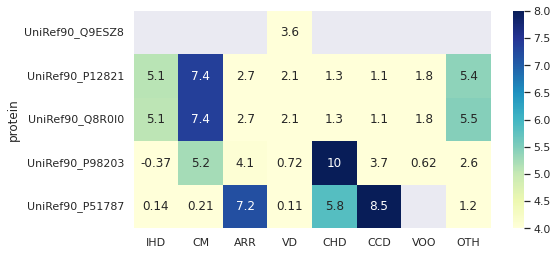

In [45]:
#heatmap of top five average

plt.figure(figsize = [8,4])
sns.heatmap(top_scores_average,\
            cmap="YlGnBu",\
            #cmap = sns.cubehelix_palette(1000),\
            #cmap = sns.cubehelix_palette(8, start=.5, rot=-.75),\
            #cmap = sns.color_palette("Blues"),\
            yticklabels=True,\
            vmin = 4,vmax = 8, \
            annot=True)

Observations: Top scoring protein is mostly blank, but it has a high average.

TODO: 
* think about how we want to present the top scoring proteins
* why is row 2 and 3 numerically similar, but they must be different in the synonyms?
* consider not showing this heatmap, it overlaps with a lot of others... (Category II or Category III)

## 3.3 Category II Protein Groups

These protein groups are above z-score for only one CVD. Determine appropriate z-score threshold, use this analysis.

In [46]:
def identify_cvd_unique_uniref_ids(zscores_df, score_threshold = 3.0, debug=False):
    
    # get list of cvds from header
    cvds = list(zscores_df.columns)

    # get unirefs which pass score threshold for that cvd
    cvd_to_unirefs = {}
    for cvd in cvds:
        # for a uniref id to be unique, it needs to pass score threshold ONLY for that CVD
        sub_df = zscores_df[ (zscores_df[cvd] >= score_threshold) ]
        cvd_to_unirefs[cvd] = set(sub_df.index)

    # find uniref ids that only show up in one cvd
    cvd_to_unique_unirefs = {}
    for this_cvd in cvds:
        unirefs = cvd_to_unirefs[this_cvd]
        for other_cvd in cvds:
            if this_cvd != other_cvd:
                unirefs = unirefs.difference(cvd_to_unirefs[other_cvd])
        cvd_to_unique_unirefs[this_cvd] = unirefs

    if debug:
        for cvd, unirefs in cvd_to_unirefs.items():
            print("%s has %d uniref ids with scores above %f"%(cvd,len(unirefs),score_threshold))
        count = 0
        for cvd, unirefs in cvd_to_unique_unirefs.items():
            print("%s has %d unique uniref ids"%(cvd,len(unirefs)))
            count += len(unirefs)
        print("In total, %d unique uniref ids"%count)
    
    return cvd_to_unique_unirefs

# Make table to show how many proteins in each group, with different threhsolds of z-scores
def zscore_cutoff_table(zscores_df):
    result_dict = {'z-score cutoff':[]}
    for thresh in [1.0,2.0,3.0,5.0,10.0]:
        # perform filtering
        cvd_to_unique_unirefs = identify_cvd_unique_uniref_ids(zscores_df,
                                                            score_threshold = thresh, 
                                                            debug = False)
        
        #initialize dict to hold values
        for cvd in cvd_to_unique_unirefs.keys():
            if cvd not in result_dict:
                result_dict[cvd] = []

        # add values to table
        result_dict['z-score cutoff'] += [thresh]
        for cvd in cvd_to_unique_unirefs.keys():
            # reports the cardinality of number of unirefs
            result_dict[cvd] += [len(cvd_to_unique_unirefs[cvd])]

    result_df = pd.DataFrame(result_dict)
    return result_df

zscore_cutoff_table(zscores_df)

,z-score cutoff,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
0,1.0,88,61,17,19,68,0,8,45
1,2.0,35,17,13,9,35,0,2,19
2,3.0,22,21,3,6,24,0,2,4
3,5.0,9,0,0,4,3,0,0,0
4,10.0,3,0,0,0,4,2,0,0


TODO:
* Look at which CVDs are most similar to CCD that cause no protein groups to be uniquely significant
* what are the 2 protein groups that show up at t=10 threshold in CCD but not for the others? -> maybe these proteins play a role in other CVDs but is most related to CCD?

In [47]:
print("z-score threshold used for this analysis: %f"%(z_score_threshold))

z-score threshold used for this analysis: 3.000000


In [48]:
# Category II: explaionaation here

category_ii_headers = []
for cvd in CVDs:
    cvd_sub = cvd + " Sub-proteome"
    cvd_catII = cvd + " Category II"

    #gets the cvds that are not the ones of current interest
    cvd_other = [other for other in CVDs if (other != cvd)]

    #accesses the sub-proteome columns of the "other" cvds
    cvd_other = [x+" Sub-proteome" for x in cvd_other]

    #the new category column is if the sub-proteome of interest is >= 3 and the other sub-proteomes are <= 3
    summary_table[cvd_catII] = summary_table[cvd_sub] & ~((summary_table[cvd_other]).any(bool_only=True,axis='columns'))

    category_ii_headers += [cvd_catII]
    
# summary_table[category_ii_headers].head()


In [49]:
# print out summary statistics
for col_name in summary_table.columns:
    if col_name in category_ii_headers:
        num_true = summary_table[col_name].sum()
        print("%s\t%d"%(col_name,num_true))

IHD Category II	22
CM Category II	21
ARR Category II	3
VD Category II	6
CHD Category II	24
CCD Category II	0
VOO Category II	2
OTH Category II	4


In [50]:
summary_table[category_ii_headers].sort_values('IHD Category II', ascending = False).head()

,IHD Category II,CM Category II,ARR Category II,VD Category II,CHD Category II,CCD Category II,VOO Category II,OTH Category II
protein,,,,,,,,
UniRef90_P18648; UniRef90_P02647,True,False,False,False,False,False,False,False
UniRef90_P05164,True,False,False,False,False,False,False,False
UniRef90_A0A8D1FEU4,True,False,False,False,False,False,False,False
UniRef90_P98106,True,False,False,False,False,False,False,False
UniRef90_Q8SQ23; UniRef90_P00750-3,True,False,False,False,False,False,False,False


In [51]:
summary_table[category_ii_headers].sort_values('CM Category II', ascending = False).head()

,IHD Category II,CM Category II,ARR Category II,VD Category II,CHD Category II,CCD Category II,VOO Category II,OTH Category II
protein,,,,,,,,
UniRef90_A0A4X1THK6; UniRef90_A0A2K5USK5,False,True,False,False,False,False,False,False
UniRef90_A0A4X1WE35; UniRef90_G3V3R6,False,True,False,False,False,False,False,False
UniRef90_I3L6S5,False,True,False,False,False,False,False,False
UniRef90_P50390,False,True,False,False,False,False,False,False
UniRef90_P62894; UniRef90_P99999,False,True,False,False,False,False,False,False


### Figure X heatmap. Top 3 in each CVD

/tmp/ipykernel_21843/1851600848.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "box_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(out_file,box_inches = 'tight')


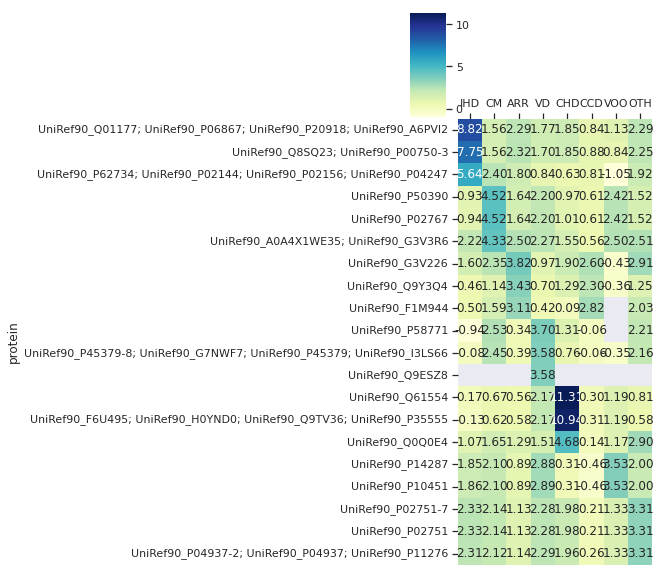

In [63]:
# heatmap for the proteins unique to each cvd

def make_category_ii_heatmap(summary_table, n=3,
                        out_file='./output/unique_unirefs_heatmap.pdf'):
    
    category_headers = [c for c in summary_table.columns if "Category II" in c]
    cvds = [c.split(" ")[0] for c in category_headers]
    
    # extract heatmap values 
    heatmap_rows = []
    for col in category_headers:
        cvd = col.split(' ')[0]
        
        # get the rows where it is true in Category II
        sub_df = summary_table[summary_table[col] == True]
        # keep the top n row names
        sub_df = sub_df.sort_values([cvd], ascending = False)
        heatmap_rows += list(sub_df.head(n).index)
#         print(list(sub_df.head(n).index))
#         print(sub_df.shape)
    heatmap_df = summary_table[summary_table.index.isin(heatmap_rows)][cvds]
    heatmap_df = heatmap_df.reindex(heatmap_rows)
    
    max_score = np.nan_to_num(heatmap_df.to_numpy()).max()
    
    # plot the heamap
    chart = sns.clustermap(heatmap_df, cmap='YlGnBu', xticklabels=True, 
                                            yticklabels=True,col_cluster=False,row_cluster=False,
                                            vmin = -1.0, vmax=max_score, annot=True, fmt='.2f',
                                            cbar_kws={"shrink": .5}, figsize=(10,20))

    chart.ax_heatmap.xaxis.tick_top() # x axis on top
    chart.ax_heatmap.xaxis.set_label_position('top')
    chart.ax_heatmap.yaxis.tick_left() # y axis on top
    chart.ax_heatmap.yaxis.set_label_position('left')

    # make it save/display in high-resolution
    fig = plt.gcf()
    fig.set_size_inches(10,8)

    # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,box_inches = 'tight')

make_category_ii_heatmap(summary_table)

In [59]:
merged[merged.index == "UniRef90_P02751-7"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P02751-7,H0Y4K8; F1SS24; H0Y7Z1,"fibronectin, Fibronectin, FN1",0.058347,0.050659,0.035483,0.048538,0.044552,0.023183,0.035426,0.063862


In [60]:
merged[merged.index == "UniRef90_P02751"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P02751,P02751,"fibronectin, Fibronectin, FN1, cold-insoluble globulin",0.058345,0.050696,0.035483,0.048537,0.044551,0.023183,0.035425,0.063861


In [61]:
merged[merged.index == "UniRef90_P04937-2; UniRef90_P04937; UniRef90_P11276"]

,Mapped Proteins,Synonyms,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Protein Groups,,,,,,,,,,
UniRef90_P04937-2; UniRef90_P04937; UniRef90_P11276,F1LST1; P04937; A0A096P6L8; P11276,"fibronectin, Fibronectin, Fn1",0.058086,0.050383,0.035511,0.048575,0.044253,0.024172,0.035453,0.063786


TODO:
* For the ones that look the same values, what are the differences? in terms of synonyms. -> explain why they're scored differently -DONE
* Fix the y-axis labels (right now not displayed). truncate? or just put UniRef90_ABCDEF* *multiple protein groups represented

CM:

UniRef90_P50390 has the protein groups A0A5S6GPG9; P50390 and the synonyms Transthyretin, prealbumin, TTHY, Prealbumin, transthyretin. 

UniRef90_P02767 has the protein groups P07309; P02767 and the synonyms TBPA, Transthyretin, prealbumin, TTHY, Prealbumin, transthyretin. 

TBPA is a synonym for UniRef90_P02767 but not for UniRef90_P50390.




VOO:

UniRef90_P14287 has the protein group P14287 and the synonyms SPP1, Osteopontin, secreted phosphoprotein 1, Secreted phosphoprotein 1, osteopontin. 

UniRef90_P10451 has the protein group P10451 and the protein groups uropontin, SPP1, Osteopontin, secreted phosphoprotein 1, Secreted phosphoprotein 1, osteopontin. 

Uropontin is a synonym for UniRef90_P10451 but not for UniRef90_P14287.



OTH: 

UniRef90_P02751-7 has the proteins H0Y4K8; F1SS24; H0Y7Z1 and the synonyms fibronectin, Fibronectin, FN1.

UniRef90_P02751 has the protein P02751 and the synonyms fibronectin, Fibronectin, FN1, cold-insoluble globulin. This entry is different from the other two because it includes cold-insoluble globin as a synonym. 

UniRef90_P04937-2; UniRef90_P04937; UniRef90_P11276	has the proteins F1LST1; P04937; A0A096P6L8; P11276 and the synonyms fibronectin, Fibronectin, Fn1. This entry is unique from the other two because Fn1 is a synonym in this entry but the other two have it as FN1. It a difference in cases.   



## 3.4 Category III Protein Groups

In [ ]:
#obtaining all the different combinations of CVDs

def get_combinations(my_list):
    '''
    This function gets every combination (in order) from my_list
    my_list is size n, this function returns combinations of sizes [2 ... n]
    '''
    combs = []
    for size in (range(2,len(my_list)+1)):
        combs += list(combinations(my_list,size))
    return combs

combs = get_combinations(CVDs)

In [ ]:
# calculate new category III columns
category_iii_headers=[]
for combination in combs:

    #gets the cvds that are not the ones of current interest 
    cvd_other = [other for other in CVDs if (other not in list(combination))] 
    # print(combination, cvd_other)

    #accesses the sub-proteome columns of the "other" cvds
    cvd_other = [x+" Sub-proteome" for x in cvd_other]

    #gets the cvds that are the ones of current interest 
    #cvd_interest = [interest for interest in CVDs if (interest == cvd)]

    #accesses the sub-proteome columns of the cvds of interest
    cvd_interest = [x+" Sub-proteome" for x in combination]

    #the new category column is if the sub-proteomes of interest are >= 3 and the other sub-proteomes are <= 3
    summary_table[combination] = ((summary_table[cvd_interest]).all(bool_only=True,axis='columns')) & ~((summary_table[cvd_other]).any(bool_only=True,axis='columns'))

    category_iii_headers += [combination]
    
summary_table[category_iii_headers].sort_values(category_iii_headers[0], ascending=False).head()


In [ ]:
# print out summary statistics
counter = 0
upset_plot_dict = {}
for col_name in summary_table.columns[25:]:
    num_true = summary_table[col_name].sum()
    if num_true != 0:
        counter = counter +1
#         print("%s\t%d"%(col_name,num_true))
        upset_plot_dict[col_name] = num_true

# print(counter)
for l,c in upset_plot_dict.items():
    print(l,c)
print(len(upset_plot_dict))

### Upset plot

In [ ]:
def get_bool_table(categories, ordering=None):
    label_ordering = []
    if ordering:
        label_ordering = ordering
    else:
        # get unique labels in alphabetical order
        unique_labels = set()
        for c in categories:
            for c_ in c:
                unique_labels.add(c)
        label_ordering = list(c)
        label_ordering.sort()

    # populate boolean arrays                                                                                                
    bool_arrays = []
    for l in label_ordering:
        b_a = []
        for c in categories:
            b = l in c
            b_a += [b]
        bool_arrays += [b_a]

    # multi index from labels and bool arrays
    multi_index = pd.MultiIndex.from_arrays(bool_arrays, names = label_ordering)
    return multi_index

multi_index_categories = get_bool_table(list(upset_plot_dict.keys()),ordering=CVDs)
# multi_index_categories
data_series = pd.Series(data=upset_plot_dict.values(),index=multi_index_categories)
data_series

In [ ]:
upplot(data_series)
plt.show()

## 3.5 Save output results

TODO: 
* need to add the synonyms and proteins back to the summary table
* save the summary table
* 

In [ ]:
!ls ../cardiac_proteome_curation/human_centric*_table.tsv
# which one should we use? I think they're the same but one
# will automatically update from the prev script.
# it's this one: human_centric_consensus_cardiac_proteome_uniref90_mapping_table.tsv

In [ ]:
!ls ../cardiac_proteome_curation/human_centric*_table.tsv
# remove the incorrect one
!rm ../cardiac_proteome_curation/human_centric_consensus_cardiac_proteome_mapping_table.tsv

In [ ]:
prot_to_uniref_file

In [ ]:
#fixing title "protein" to "protein group" in summary_table
summary_table = summary_table.rename_axis('protein group')

In [ ]:
# write table
summary_table.to_csv('SupplementaryTableX.csv')

In [ ]:
# write protein lists in subproteomes, category I proteins, category II proteins, category III proteins, etc.
# basically, the ones we need for the pathway analysis save them in output folder.

In [ ]:
unirefs = list(all_cvds_uniref_zscores_df['protein'])
out_file_name = out_directory + "all_cvds_unirefs.txt"
with open(out_file_name, "w") as out_file:
        out_file.write("\n".join(unirefs))
        print("Wrote %d lines to %s"%(len(unirefs),out_file_name))
        uniref_files += [out_file_name]

In [ ]:
# get uniref and proteins for each cvd
cvd_to_uniref_identified = {}
cvd_to_proteins_identified = {}
for cvd in cvds:
    unirefs = set(df_bool[df_bool[cvd]]['protein'])
    proteins = set()
    for u in unirefs:
        for p in uniref_to_uniprot_list[u]:
            proteins.add(p)
    cvd_to_uniref_identified[cvd] = unirefs
    cvd_to_proteins_identified[cvd] = proteins
    print("%s has %d uniref IDs with non-zero score "%(cvd,len(unirefs)))

for cvd, unirefs in cvd_to_uniref_identified.items():
    out_file_name = out_directory + cvd + "_nonzero_unirefs.txt"
    with open(out_file_name, "w") as out_file:
        out_file.write("\n".join(list(unirefs)))
        print("Wrote %d lines to %s"%(len(unirefs),out_file_name))
        uniref_files += [out_file_name]

In [ ]:
uniref_files = []
out_directory = "./results/"
for cvd, unirefs in cvd_to_unique_unirefs.items():
    out_file_name = out_directory + cvd + "_unique_unirefs.txt"
    with open(out_file_name, "w") as out_file:
        out_file.write("\n".join(list(unirefs)))
        print("Wrote %d lines to %s"%(len(unirefs),out_file_name))
        uniref_files += [out_file_name]

# 4. Pathway Analysis

In [ ]:
import json
import csv
import requests
import pandas
import urllib
import json

def download_reactome_pathway_analysis_results(token, out_file = "results.csv"):
    '''
    This downloads the results from a Reactome Pathway Analysis via its token as out_file
    '''
    # prepare parameters for curl command
    headers = {
        'accept': '*/*',
    }
    url = 'https://reactome.org/AnalysisService/download/%s/pathways/TOTAL/result.csv'%(token)
    
    # post request
    response = requests.get(url, headers=headers)

    if "error" in response.text:
        print("Error occured")
        print(response.text)
        return
    
    # parse csv files, ignore comma within quotation marks
    data = [l for l in csv.reader(response.text.splitlines(), quotechar='"', delimiter=',',
                     quoting=csv.QUOTE_ALL, skipinitialspace=True)]

    # convert to pandas DataFrame, rename and drop empty columns
    df = pd.DataFrame(data)
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    df = df.loc[:, df.columns.notna()]
    
    # save a csv
    if out_file:
        df.to_csv(out_file,index=False)
        print("Saved to file %s"%out_file)
    
    return df

def submit_reactome_pathway_analysis(protein_list, out_file='results.csv', debug=False):
    '''
    This is Reactome Pathway Analysis using project to human.
    Source: https://reactome.org/AnalysisService/#/identifiers/getPostTextToHuman
    '''
    # prepare parameters for curl command
    headers = {
        'accept': '*/*',
        'Content-Type': 'text/plain',
    }
    params = {
        'interactors': 'false',
        'pageSize': '20',
        'page': '1',
        'sortBy': 'ENTITIES_PVALUE',
        'order': 'ASC',
        'resource': 'TOTAL',
        'pValue': '1',
        'includeDisease': 'true',
    }

    # prepare input data
    data = "\n".join(protein_list)

    # post request
    response = requests.post('https://reactome.org/AnalysisService/identifiers/projection', 
                             params=params, headers=headers, data=data)
    
    # extract token
    result_dict = json.loads(response.text)
    token = result_dict['summary']['token']
    token = urllib.parse.quote(token) # format for url
    
    if debug:
        print("Sucessfully posted pathway analysis with token %s"%(result_dict['summary']['token']))
    
    # download result
    result_df = download_reactome_pathway_analysis_results(token, out_file)
    
    return result_df

In [ ]:
def convert_uniref_ids_to_proteins(uniref_id_list, uniref_to_uniprot_list):
    plist = set()
#     for uniref_ids in list_uniref_ids.split("; "):
    for l in uniref_id_list:
        uniref_ids = l.split("; ")
        for uniref_id in uniref_ids:
#             print(uniref_id)
            proteins = uniref_to_uniprot_list[uniref_id]
            plist = plist.union(set(proteins))
    return plist

### cvd subproteome protein lists ###
print("### CVD Sub-proteomes ###")
cvd_subproteome_unirefs = {}
cvd_subproteome_proteins = {}
for cvd in cvds:
    tag = "%s Sub-proteome"%(cvd)
    unirefs = list(summary_table[summary_table[tag]].index)
    proteins = convert_uniref_ids_to_proteins(unirefs,uniref_to_uniprot_list)
    print("%s: %d unirefs %d proteins"%(tag, len(unirefs),len(proteins)))

    cvd_subproteome_unirefs[cvd] = unirefs
    cvd_subproteome_proteins[cvd] = proteins
    
### category i protein lists ###
print("### Category I ###")
category_i_unirefs = list(summary_table[summary_table['Category I']].index)
category_i_proteins = convert_uniref_ids_to_proteins(category_i_unirefs,uniref_to_uniprot_list)
print("%d uniref ids and %d uniref proteins in Category I"%(len(category_i_unirefs),len(category_i_proteins)))

### category ii protein lists ###
print("### Category II ###")
category_ii_unirefs = {}
category_ii_proteins = {}
for cvd in cvds:
    tag = "%s Category II"%(cvd)
    unirefs = list(summary_table[summary_table[tag]].index)
    proteins = convert_uniref_ids_to_proteins(unirefs,uniref_to_uniprot_list)
    print("%s: %d unirefs %d proteins"%(tag, len(unirefs),len(proteins)))

    category_ii_unirefs[cvd] = unirefs
    category_ii_proteins[cvd] = proteins

In [ ]:
for cvd in cvds:
    proteins = cvd_subproteome_proteins[cvd]
    
    if len(proteins) > 0:
        out_name = "./reactome_results/%s_subproteome_pathway_analysis_result.csv"%cvd
        pwa_df = submit_reactome_pathway_analysis(proteins, out_file = out_name)
        num_pathways = pwa_df.shape[0]
        print("%d pathways identified. Saved to %s"%(num_pathways,out_name))
    else:
        print("Insufficient number of proteins for %s"%cvd)

In [ ]:
# run pathway analysis for category i proteins
cat_i_pa_result_df = submit_reactome_pathway_analysis(category_i_proteins, debug=True,
                            out_file = "./reactome_results/category_i_proteins_pathway_analysis_result.csv")
cat_i_pa_result_df.head()

In [ ]:
category_ii_pa_df = {}
for cvd in cvds:
    proteins = category_ii_proteins[cvd]
    
    if len(proteins) > 0:
        out_name = "./reactome_results/%s_category_ii_pathway_analysis_result.csv"%cvd
        pwa_df = submit_reactome_pathway_analysis(proteins, out_file = out_name)
        num_pathways = pwa_df.shape[0]
        print("%d pathways identified. Saved to %s"%(num_pathways,out_name))
    else:
        print("Insufficient number of proteins for %s"%cvd)

In [ ]:
# all proteins?
all_unirefs = list(uniref_to_uniprot_list.keys())
all_proteins = set()
for proteins in uniref_to_uniprot_list.values():
    all_proteins = all_proteins.union(set(proteins))
print("%d unirefs and %d proteins"%(len(all_unirefs),len(all_proteins)))

out_name = "./reactome_results/all_proteins_pathway_analysis_result.csv"
pwa_df = submit_reactome_pathway_analysis(all_proteins, out_file = out_name)
num_pathways = pwa_df.shape[0]
print("%d pathways identified. Saved to %s"%(num_pathways,out_name))

In [ ]:
# proteins that had a score in each CVD at ALL
nonzero_cvd_uniref = {}
nonzero_cvd_proteins = {}
for cvd in cvds:
    
    # extract proteins
    unirefs = list(summary_table[summary_table[cvd] > 0].index)
    proteins = convert_uniref_ids_to_proteins(unirefs,uniref_to_uniprot_list)
    nonzero_cvd_uniref[cvd] = unirefs
    nonzero_cvd_proteins[cvd] = proteins
    print("%s: %d unirefs %d proteins"%(cvd, len(unirefs),len(proteins)))
    
    # pathway analysis
    if len(proteins) > 0:
        out_name = "./reactome_results/%s_nonzero_proteins_pathway_analysis_result.csv"%cvd
        pwa_df = submit_reactome_pathway_analysis(proteins, out_file = out_name)
        num_pathways = pwa_df.shape[0]
        print("%d pathways identified. Saved to %s"%(num_pathways,out_name))
    else:
        print("Insufficient number of proteins for %s"%cvd)

# Load Reactome Data

In [ ]:
# Imported functions from Alex's github repo
# source: https://github.com/arpelletier/dglke_workspace/blob/main/bin/kg_utils.py

'''
This function reads the hierarchy information from Reactome and only returns the pathway ID's
which are for humans (HSA). These relationships are represented as an edge between a pair of nodes,
reported as (ancestor_pathway, decendent_pathway). Although this information isn't typically used,
these information is important to identify root pathways (pathways with no ancestors) and leaf
pathways (pathways with no decendents) by looking at the in/out degree with a directed graph.
This function also returns the set of unique reactome ids found in these relationships.
'''


def extract_human_hierarchical_information(reactome_hierarchy_to_pathway_file):
    # Read hierarchical information
    reactome_hierarchical_information = [f.strip("\n").split("\t")
                                         for f in open(reactome_hierarchy_to_pathway_file, 'r').readlines()]

    human_reactome_hierarchical_info = []
    for v1, v2 in reactome_hierarchical_information:
        if "HSA" in v1 and "HSA" in v2:
            human_reactome_hierarchical_info += [(v1, v2)]

    # Describe the data
    unique_human_reactome_ids = set()
    for v1, v2 in human_reactome_hierarchical_info:
        unique_human_reactome_ids.add(v1)
        unique_human_reactome_ids.add(v2)

    print("Number of edges: " + str(len(human_reactome_hierarchical_info)))
    print("Number of nodes: " + str(len(unique_human_reactome_ids)))
    return human_reactome_hierarchical_info, unique_human_reactome_ids


'''
This function reports the set of proteins corresponding to a pathway_id found in the input file. This
information is found in the reactome_uniprot_to_pathway_file table downloaded from the Reactome
website. Exclude isoforms removes protein accession which correspond to a protein isoform, reporting
only the cannonical protein accession instead.
'''


def extract_pathway_to_proteins(reactome_uniprot_to_pathway_file,
                                exclude_isoforms=True):
    # Load file for mapping reactome id -> proteins
    reactome_uniprot_to_pathway_table = pd.read_csv(reactome_uniprot_to_pathway_file, sep='\t', header=None)
    reactome_uniprot_to_pathway_table.columns = ["Uniprot", "Pathway identifier", "URL", "Pathway name", "X",
                                                 "Organism"]

    # add all proteins to each pathway set
    pathway_to_unique_proteins = {}
    for protein, pathway in zip(reactome_uniprot_to_pathway_table['Uniprot'],
                                reactome_uniprot_to_pathway_table['Pathway identifier']):
        # initialize set for each pathway
        if pathway not in pathway_to_unique_proteins:
            pathway_to_unique_proteins[pathway] = set()
        pathway_to_unique_proteins[pathway].add(protein)

    # remove protein isoforms
    if exclude_isoforms:
        for pathway in pathway_to_unique_proteins.keys():

            # identify isoforms
            isoforms = set()
            for protein in pathway_to_unique_proteins[pathway]:
                if "-" in protein:
                    isoforms.add(protein)

            # remove isoforms and add base protein
            for protein in isoforms:
                base_protein = protein.split("-")[0]
                pathway_to_unique_proteins[pathway].remove(protein)
                pathway_to_unique_proteins[pathway].add(base_protein)

    # Information about what we gathered
    num_proteins_per_pathway = []
    for pathway in pathway_to_unique_proteins.keys():
        proteins = pathway_to_unique_proteins[pathway]
        num_proteins_per_pathway += [len(proteins)]
    num_proteins_frequency = {x: num_proteins_per_pathway.count(x) for x in num_proteins_per_pathway}
    num_pathways_with_non_zero_proteins = 0
    for i in num_proteins_frequency.keys():
        freq = num_proteins_frequency[i]
        if i > 0:
            num_pathways_with_non_zero_proteins += freq
    arr = np.array(num_proteins_per_pathway)
    mean_num_proteins = np.mean(arr)
    median_num_proteins = np.median(arr)
    stdev_num_proteins = np.std(arr)

    # Describe the data
    print("Number of pathways extracted: " + str(len(pathway_to_unique_proteins)))
    print("Number of pathways extracted with > 0 proteins: " + str(num_pathways_with_non_zero_proteins))
    print("Mean pathway size: " + str(mean_num_proteins))
    print("Median pathway size: " + str(median_num_proteins))
    print("Standard deviation pathway size: " + str(stdev_num_proteins))

    return pathway_to_unique_proteins


'''
Returns a dict mapping pathway id -> pathway name
'''


def extract_pathway_id_to_pathway_name(file_name):
    reactome_id_to_pathway_name_lines = [f.strip("\n").split("\t") for f in
                                         open(file_name, 'r').readlines()]
    pathway_id_to_name = {}
    for line in reactome_id_to_pathway_name_lines:
        pathway_id_to_name[line[0]] = line[1]
    return pathway_id_to_name


'''
This function returns a list of pathways which are the descendants of each pathway in ancestor_list. sort_by_size will sort
the list based on the number of descendants it has. If largest_first, the sorted list will be in the order of largest number
of descendants first, otherwise it will be smallest first. Each pathway is added to the list of its ancestor pathways in the
specified order. If remove_duplicates is true, each descendant will only show up in the first ancestor list it has appeared.
After removing duplicates, the lists will not necessarily be sorted, as the size of each pathway has changed upon removing
duplicate nodes.
'''


def get_descendant_pathways(ancestor_list, G, sort_by_size=True,
                            largest_first=True,
                            remove_duplicates=True):
    pair_nodes = []
    for root_node in ancestor_list:
        bfs_traversal = ([root_node] +
                         [v1 for v1, v2 in
                          list(nx.algorithms.traversal.breadth_first_search.bfs_predecessors(G, root_node))])
        # print(bfs_traversal)
        # print(root_node+" has "+str(len(bfs_traversal))+" nodes in its pathway")
        pair_nodes += [(bfs_traversal, len(bfs_traversal))]

    if sort_by_size:
        pair_nodes.sort(key=lambda x: x[1])

        if largest_first:
            pair_nodes = pair_nodes[::-1]

    filtered_list = []
    if remove_duplicates:
        used_pathways = set()
        for nodes, size in pair_nodes:
            node_list = []
            for node in nodes:
                if node not in used_pathways:
                    node_list += [node]
                    used_pathways.add(node)
            if len(node_list) > 0:
                filtered_list += [(node_list, len(node_list))]
            else:
                # it seems there is a parent pathway which is labeled by another parent pathway, so...
                # this is redundant...
                filtered_list += [([nodes[0]], 0)]
    else:
        filtered_list = pair_nodes

    # want to have root path in position 0 and list in position 1
    return_list = []
    for nodes, size in filtered_list:
        # print(pathway_id_to_pathway_name[nodes[0]] + " has " + str(size) + " nodes")
        return_list += [(nodes[0], nodes)]
    return return_list


'''
Perform this function after calling get_descendant_pathways. It creates a reverse mapping of descendant -> ancestor.
For this to work properly, you should remove the duplicate pathways such that one pathway only shows up in one ancestor list.
'''


def get_familiar_relations(descendants):
    relations = {}
    for family, members in descendants:
        for member in members:
            relations[member] = family
    return relations


from scipy.cluster.hierarchy import dendrogram

'''
This function prunes edges of the DAG, breaking ties with a labeling function. Edges between a descendant and ancestor which
share the same label will be preserved. If no labeling function is provided or if there are multiple ancestors with the same 
label, then the ancestor which has a larger subtree (larger number of total descendants) is retained. All other descendant-
ancestor edges are pruned from the DAG. The resulting structure should be a tree.
'''


def prune_extra_edges(G, labeling_function=None, debug=False):
    nodes = G.nodes()
    leaves = set(n for n in nodes if G.out_degree(n) == 0)
    roots = set(n for n in nodes if G.in_degree(n) == 0)
    inner_nodes = [n for n in nodes if G.out_degree(n) > 0]

    # Compute the direct decendants and ancestors of each node
    descendants = dict()
    ancestors = dict()
    for ancestor in dict(G.adjacency()).keys():
        children_dict = dict(G.adjacency())[ancestor]
        children = list(children_dict.keys())
        descendants[ancestor] = children
        for child in children:
            if child not in ancestors:
                ancestors[child] = []
            if ancestor not in ancestors[child]:
                ancestors[child] += [ancestor]

    if (debug):
        print("Descendants: ")
        print(descendants)
        print("Ancestors: ")
        print(ancestors)

    # Compute the size of each subtree number of nodes
    subtree = dict((n, [n]) for n in leaves)
    for u in inner_nodes:
        children = set()
        nodes = list(descendants[u])
        while len(nodes) > 0:
            v = nodes.pop(0)
            children.add(v)
            nodes += descendants[v]
        subtree[u] = sorted(children)

    if (debug):
        print("Subtree: ")
        print(subtree)

    # identify those in the tree with extra edges
    extra_edges_nodes = [x for x in G.nodes() if G.in_degree(x) > 1]

    if (debug):
        print("Number of nodes with extra edges: " + str(len(extra_edges_nodes)))

    # make a copy of graph, add root node
    pruned_G = G.copy()
    for node in roots:
        pruned_G.add_edge("Root", node)

    # prune edges from extra_edges
    num_edges_pruned = 0
    for node in extra_edges_nodes:

        # there are necessarily more than one ancestor
        parents = ancestors[node]
        # store the node name and subtree size of the ancestor you want to keep
        keep_this_parent = ("", 0)

        # extract node label if labeling function exists
        node_label = None
        if labeling_function != None and node in labeling_function:
            node_label = labeling_function[node]

        if (debug):
            print(node)
            print(node_label)

        # determine which parent to keep
        for parent in parents:

            # extract parent label if labeling function exists
            parent_label = None
            if labeling_function != None and parent in labeling_function:
                parent_label = labeling_function[parent]

            if (debug):
                print(parent)
                print(parent_label)

            # keep the parent if it matches the labeling function of node
            if node_label == parent_label:
                subtree_size = len(subtree[parent])

                # keep the parent with largest subtree
                if subtree_size > keep_this_parent[1]:
                    keep_this_parent = (parent, subtree_size)

        # Rare case where parent label does not match node label
        if len(keep_this_parent[0]) < 1:
            # keep the parent pathway with the laregest subtree
            for parent in parents:
                subtree_size = len(subtree[parent])
                if subtree_size > keep_this_parent[1]:
                    keep_this_parent = (parent, subtree_size)

        # prune the edges to parents we aren't keeping
        if (debug):
            print("Decided to keep " + keep_this_parent[0] + ", with subtree size " + str(keep_this_parent[1]))

        for parent in parents:
            if parent != keep_this_parent[0]:
                # remove edge from graph
                pruned_G.remove_edge(parent, node)
                num_edges_pruned += 1

    print("Pruned " + str(num_edges_pruned) + " edges.")

    return pruned_G


'''
For every node in the node_list, this function computes the descendant->ancestor->root path on the graph.
Returned value is a dictionary of node -> path.
'''


def path_to_root(G, node_list, debug=False):
    # check to see if it is a tree
    if not nx.is_tree(G):
        print("Graph is not a tree! Please prune the unwanted edges first!")
        return
    elif debug:
        print("Graph is a tree.")

    rev_G = G.reverse()
    paths = dict()
    for node in node_list:
        bfs = list(nx.algorithms.traversal.breadth_first_search.bfs_successors(rev_G, node))
        path = [node]
        for descendant_node, parent_nodes in bfs:
            # take only the first parent node
            parent = parent_nodes[0]

            # ignore the paths corresponding to a parent node we did not select
            # this was originally to account for nodes with multiple parents, but if you pruned the tree
            # first, this is not an issue.
            if descendant_node in path:
                path += [parent]
        paths[node] = path
    return paths


'''
This function takes a sub-graph of the original graph returning only the nodes in the node_list and all of its
ancestor nodes, up to and including the root node. As well, any intermediate (non-leaf) nodes in the node list are
represented with a leaf node, flagged by "_leaf" suffix. The input graph should be a tree, not a DAG. 
'''


def construct_hierarchy_subgraph(G, node_list, debug=False):
    # node path to root for every node in node_list
    node_list_paths_to_root = path_to_root(G, node_list)

    # preserve the node_list but replace the "_leaf" labeled ones
    new_node_list = node_list.copy()

    # add every pair of edges to the new graph
    sub_G = nx.DiGraph()
    edges = []
    for node in node_list:
        path = node_list_paths_to_root[node]

        for i in range(len(path) - 1):
            to_node = path[i]
            from_node = path[i + 1]
            edges += [(from_node, to_node)]

        # add edges for daughter nodes which are parents of another daughter node
        for node in path[1:]:
            leaf_node = node + "_leaf"
            if node in node_list and leaf_node not in new_node_list:
                edges += [(node, leaf_node)]
                # replace name in new node list
                new_node_list = [n.replace(node, leaf_node) for n in new_node_list]
    sub_G.add_edges_from(edges)

    return sub_G, new_node_list


'''
Constructs a linkage matrix for a hierarchy tree. The input graph must be a DAG. The leaves of the dendrogram are specified
by the node_list. The graph is first pruned using a labeling function if provided, converting the graph into a tree if it
is not already. A sub-tree is then extracted, keeping only the necessary nodes in node_list and all of its ancestors. If a
node in the node_list is not a leaf node, then a new node will be added to make it so. This is necessary to construct the
dendrogram.
'''


def construct_dendrogram(G, node_list, labeling_function=None, debug=False):
    # prune the graph into a tree
    pruned_G = prune_extra_edges(G, labeling_function=labeling_function)

    # extract only relevant nodes from graph
    sub_G, leaves = construct_hierarchy_subgraph(pruned_G, node_list)

    nodes = sub_G.nodes()
    inner_nodes = [n for n in nodes if sub_G.out_degree(n) > 0]

    if (debug):
        print("Number of nodes in node_list: " + str(len(node_list)))
        print("Number of leaf nodes in subgraph: " + str(len(leaves)))
        print("Number of nodes in node_list but not in leaves: " + str(len(set(node_list).difference(set(leaves)))))
        print("Number of nodes in leaves but not in node_list: " + str(len(set(leaves).difference(set(node_list)))))

    # Compute the direct decendants of each node
    descendants = dict()
    for key in dict(sub_G.adjacency()).keys():
        children_dict = dict(sub_G.adjacency())[key]
        children = list(children_dict.keys())
        descendants[key] = children
    if (debug):
        print(descendants)

    # Compute the size of each subtree number of nodes
    subtree = dict((n, [n]) for n in leaves)
    # Compute the size (i.e. how many leaf nodes) of each subtree
    leaf_subtree = dict((n, [n]) for n in leaves)
    for u in inner_nodes:
        children = set()
        nodes = list(descendants[u])
        while len(nodes) > 0:
            v = nodes.pop(0)
            children.add(v)
            nodes += descendants[v]
        subtree[u] = sorted(children)
        leaf_subtree[u] = sorted(children & set(leaves))
    if (debug):
        print("Subtree: ")
        print(subtree)
        print("Leaf subtree: ")
        print(leaf_subtree)

    # Compute the depth of each node in subtree
    depth_from_root = nx.shortest_path_length(sub_G, "Root")
    max_depth = max(depth_from_root.values())
    height_of_dendrogram = {node: (max_depth - depth) for node, depth in
                            zip(depth_from_root.keys(), depth_from_root.values())}

    # Compute the linkage matrix
    inner_nodes.sort(key=lambda n: len(subtree[n]))  # <-- order inner nodes ascending by subtree size, root is last
    if (debug):
        print("inner nodes:")
        print(inner_nodes)
    node_to_index = {}
    num_unique_indexes = 0
    for node in leaves:
        node_to_index[node] = num_unique_indexes
        num_unique_indexes += 1

    if (debug):
        print(node_to_index)

    linkage_matrix = []
    for ancestor_node in inner_nodes:
        if (debug):
            print("Ancestor node: " + ancestor_node)

        children = descendants[ancestor_node]
        if len(children) > 1:
            # merge the branches if there are more than 1 children
            for j in range(len(children) - 1):
                child_1 = children[j]
                child_2 = children[j + 1]
                child_1_index = node_to_index[child_1]
                child_2_index = node_to_index[child_2]
                node_to_index[ancestor_node] = num_unique_indexes
                linkage_matrix += [[float(child_1_index),
                                    float(child_2_index),
                                    float(len(subtree[ancestor_node])),
                                    float(len(leaf_subtree[ancestor_node]))]]
                if (debug):
                    print("Combine " + child_1 + " and " + child_2 + " into ancestor node " + ancestor_node +
                          ", index: " + str(node_to_index[ancestor_node]))
                node_to_index[child_1] = node_to_index[ancestor_node]
                node_to_index[child_2] = node_to_index[ancestor_node]
                num_unique_indexes += 1
        else:
            # otherwise, the ancestor inherits the index of its single child
            node_to_index[ancestor_node] = node_to_index[children[0]]
            if (debug):
                print("Ancestor node " + ancestor_node + " inherits the index of its single child "
                      + children[0] + ", index: " + str(node_to_index[ancestor_node]))

    # Visualize
    dend = dendrogram(linkage_matrix, labels=leaves, leaf_rotation=90)
    dendrogram_leaf_order = dend['ivl'][::-1]
    plt.show()

    return linkage_matrix, dendrogram_leaf_order



In [ ]:
# Load in the reactome hierarchial information for human. See function definition in first cell.
hierarchical_relationships, unique_reactome_ids = \
    extract_human_hierarchical_information(reactome_hierarchy_to_pathway)

# Load in pathway id to proteins relationships. See function definition in first cell.
reactome_pathway_to_unique_proteins = extract_pathway_to_proteins(reactome_uniprot_to_pathway,
                                            exclude_isoforms = False)

# Load in mapping of reactome pathway id to pathway name
pathway_id_to_pathway_name = extract_pathway_id_to_pathway_name(reactome_id_to_pathway_name)

In [ ]:
# Create the graph
G = nx.DiGraph()
G.name = 'Reactome hierarchical tree'
G.add_edges_from(hierarchical_relationships)
print(nx.info(G))

In [ ]:
# Calculate the familiar relations of each node
# That is, label a node based on its membership as a descendent of a specific set of pathways (root and parent pathways)

root_nodes = [x for x in G.nodes() if G.out_degree(x)>0 and G.in_degree(x)==0]
print("Number of root nodes: "+str(len(root_nodes)))

print("### Root Pathway Descendants ###")
descendants = get_descendant_pathways(root_nodes, G)
root_pathway_familiar_relations = get_familiar_relations(descendants)

In [ ]:
# Prune graph based on membership to root pathway
pruned_G_root_pathways = prune_extra_edges(G, 
                            labeling_function = root_pathway_familiar_relations, 
                            debug=False)
pruned_G_root_pathways.name = 'Reactome hierarchical tree pruned with root pathway membership'
print(nx.info(pruned_G_root_pathways))

# Gather data for Pathway Analysis Heatmap in common between CVDs

In [ ]:
# read all pathway analysis results into dataframes

pathway_analysis_directory = './reactome_results'
title_to_df = {}
for filename in os.listdir(pathway_analysis_directory):
    if filename.endswith(".csv"):
        pwa_file = os.path.join(pathway_analysis_directory, filename)
        
        # rename some keys for formatting
        tag = filename.split("_")[0] # cvd abbreviation
        if "category_ii" in filename:
            tag += "_unique"
        elif "subproteome" in filename:
            tag += '_subproteome'
        elif "nonzero" in filename:
            tag += "_nonzero"
        elif "category_i" in filename:
            tag = "category_i"
        elif "all" in filename:
            tag = "all_proteins"
        
        title_to_df[tag] = pd.read_csv(pwa_file)
        
    else:
        continue
reactome_results = title_to_df['category_i']
print(title_to_df.keys())

In [ ]:
def extract_coverage(df, pathway_list):
    '''
    This returns the 'coverage' of a pathway based on proteins from a condition
    based on the pathways in pathway_list
    Calculate coverage using #Entities found / #Entities total
    '''

    # use the pathway ID's and get the rows for each cvd from this list
    sub_df = df[df['Pathway identifier'].isin(pathway_list)].copy()
    # Calculate coverage using #Entities found / #Entities total
    sub_df['coverage'] = sub_df['#Entities found'] / sub_df['#Entities total']
    
    # put as a dict, to extract in the correct order
    coverages_dict = dict(zip(sub_df['Pathway identifier'],sub_df['coverage']))
    # fill in missing data with 0
    for pid in pathway_list:
        if pid not in coverages_dict:
            coverages_dict[pid] = 0
    coverages = [coverages_dict[pid] for pid in pathway_list]
    
    return coverages

def convert_to_pathway_name(df, pathways_to_include):
    '''
    Convert pathway IDs to pathway name.
    Borrows a Reactome PA dataframe and returns the appropriate names in order
    '''
    id_to_name = dict(zip(df['Pathway identifier'], df['Pathway name']))
    return [id_to_name[p] for p in pathways_to_include]


def extract_heatmap_data(title_to_df, pval_cutoff = 0.05, max_num = 15):
    '''
    Calculates the coverage for each CVD, based on the top num_rows pathways
    found in the 'all' analysis. 
    num_rows: The number of Reactome Pathways we want to keep as top n from 'all'
    '''    

    # extract the pathway ID's for the first n rows from all protein analysis
    all_df = title_to_df['category_i']
#     print(all_df.head())
    pathways_to_include = list(all_df[all_df['Entities pValue'] < pval_cutoff]['Pathway identifier'].head(n=max_num))
    print(len(pathways_to_include))
    # assemble data for heatmap
    headers = [] # stores cvd names
    coverages = [] # stores the coverage values
    for df_title in title_to_df.keys():
        if "nonzero" in df_title: # only take those with nonzero value
            cvd = df_title.split("_")[0]
            coverage = extract_coverage(title_to_df[df_title], pathways_to_include)
            coverages += [coverage]
            headers += [cvd]
    # make into dataframe
    df = pd.DataFrame(coverages)
    df.columns = convert_to_pathway_name(all_df, pathways_to_include) # set row names
    df = df.T # invert
    df.columns = [h.split("_")[0] for h in headers] # set column names
    return df, pathways_to_include

# make heatmap using these values
heatmap_data, pathways_in_heatmap = extract_heatmap_data(title_to_df)
heatmap_data = heatmap_data[cvds]
heatmap_data

In [ ]:
# remove these pathways from the heatmap
pathway_names_to_drop = ['Signaling downstream of RAS mutants',
                                                 'Paradoxical activation of RAF signaling by kinase inactive BRAF']
heatmap_data = heatmap_data.drop(labels=pathway_names_to_drop,axis=0)

# also need to drop them from the pathways_in_heatmap pathway id list
pids_to_remove = []
for pid in pathways_in_heatmap:
    pname = pathway_id_to_pathway_name[pid]

    if pname in pathway_names_to_drop:
        pids_to_remove += [pid]
for pid in pids_to_remove:
    pathways_in_heatmap.remove(pid)
    pname = pathway_id_to_pathway_name[pid]
    print("dropped %s, %s"%(pid,pname))
print(pathways_in_heatmap)
heatmap_data

In [ ]:
print(pathways_in_heatmap)
print([pathway_id_to_pathway_name[p] for p in pathways_in_heatmap])

In [ ]:
def extract_pathway_to_scores(pathways_to_extract, uniref_to_score_df, 
                                                            reactome_results_df, uniprot_to_uniref, debug=False):
    '''
    '''
#     cvds = list(uniref_to_score_df.copy().drop('protein', axis=1).columns) 
    cvds = list(uniref_to_score_df.copy())
                
    # step 1: get matching proteins in each pathway
    pathway_to_proteins = {}
    for pathway in pathways_to_extract:
        sub_df = reactome_results_df[reactome_results_df['Pathway identifier'] == pathway]
        temp1 = list(sub_df['Submitted entities found'])[0].split(";")
#         temp2 = list(sub_df['Mapped entities'])[0].split(";")
        pathway_to_proteins[pathway] = temp1

    # step 2: get matching unirefs in each pathway
    pathway_to_unirefs = {}
    for pathway in pathways_to_extract:
        proteins = pathway_to_proteins[pathway]
        unirefs = set()
        for p in proteins:
            if p in uniprot_to_uniref:
                uniref = uniprot_to_uniref[p]
                unirefs.add(uniref)
                # print("%s maps to %s"%(p,uniref))
            # else:
                # print("%s not in uniprot to uniref mapping"%p)
        pathway_to_unirefs[pathway] = list(unirefs)
    # print(pathway_to_unirefs)

    # # step 3: convert uniref_to_score_df to protein level df
    # protein_to_score_df = {}

    # step 4: extract relevant uniref_to_score_df subset for each pathway
    pathway_to_uniref_scores = {}
    for pathway, unirefs in pathway_to_unirefs.items():
        sub_df = uniref_to_score_df[uniref_to_score_df.index.isin(unirefs)]
        pathway_to_uniref_scores[pathway] = sub_df

    # # step 5: extract relevant protein_to_score_df subset for each pathway
    # pathway_to_protein_scores = {}

    # step 6: debug and return
    if debug:
        summary_df = {'Pathway ID':[],'Pathway size':[]}
        for cvd in cvds:
            summary_df[cvd] = [] 
        for pathway in pathways_to_extract:
            sub_df = reactome_results_df[reactome_results_df['Pathway identifier'] == pathway]
            pathway_size = list(sub_df['#Entities total'])[0]
            uniref_score_df = pathway_to_uniref_scores[pathway]
            # protein_score_df = pathway_to_protein_scores[pathway]
            summary_df['Pathway ID'] += [pathway]
            summary_df['Pathway size'] += [pathway_size]
            # print(uniref_score_df)
            for cvd in cvds:
                num_unirefs = uniref_score_df.shape[0] - (uniref_score_df[cvd].isna()).sum()
                temp_text = str(num_unirefs)
                # num_proteins = ...
                # temp_text = "(%d, %d)"%(num_unirefs,num_proteins)
                summary_df[cvd] += [temp_text]
        summary_df = pd.DataFrame(summary_df)
        print(summary_df)

    return pathway_to_uniref_scores


def get_uniref_to_uniprot_list(prot_to_uniref_file, reverse_mapping=False):
    # map uniref IDs back to proteins
    map_df = pd.read_csv(prot_to_uniref_file, sep = "\t")
    map_df.columns = ['UniProt list','UniRef90']
    uniref_to_uniprot_list = {}
    for upid_list, uniref_id in zip(map_df['UniProt list'], map_df['UniRef90']):
        uniref_to_uniprot_list[uniref_id] = upid_list.split(",")
    if not reverse_mapping:
        return uniref_to_uniprot_list
    else:
        uniprot_to_uniref_list = {}
        for uniref, uniprots in uniref_to_uniprot_list.items():
            for uniprot in uniprots:
                uniprot_to_uniref_list[uniprot] = uniref
        return uniprot_to_uniref_list


def extract_pathway_avg_zscore_matrix(pathway_to_uniref_scores):
    score_dict = {'Pathway':[]}
    for pathway, uniref_scores_df in pathway_to_uniref_scores.items():
        cvds = list(uniref_scores_df.copy().columns) 
#         cvds = list(uniref_scores_df.copy().drop('protein', axis=1).columns) 
        for cvd in cvds:
            if cvd not in score_dict:
                score_dict[cvd] = []
            avg_zscore = np.mean(uniref_scores_df[cvd])
            score_dict[cvd] += [avg_zscore]
        score_dict['Pathway'] += [pathway]
    z_data = pd.DataFrame(score_dict).set_index('Pathway')
    return z_data


# the results of putting all the proteins into reactome pathway analysis
all_union_pa_df = title_to_df['all_proteins']

# get reverse and forward mapping of uniprot proteins to uniref90 groups
uniref_to_uniprot_list = get_uniref_to_uniprot_list(prot_to_uniref_file)
uniprot_to_uniref = get_uniref_to_uniprot_list(prot_to_uniref_file, reverse_mapping=True)

# extract pathway to its set of corresponding CaseOLAP scores for each protein in that pathway
pathway_to_uniref_scores = extract_pathway_to_scores(pathways_in_heatmap, zscores_df, 
                                                    all_union_pa_df, uniprot_to_uniref, debug=True)

c_data = heatmap_data[cvds]
z_data = extract_pathway_avg_zscore_matrix(pathway_to_uniref_scores)
# relabel rows and reorder columns
z_data.index = [pathway_id_to_pathway_name[p] for p in z_data.index]
z_data = z_data[cvds]
# dend_data = linkage_matrix

In [ ]:
z_data

## Heatmap 1

In [ ]:
def make_heatmap(data, v_lim = (0.0,1.0), ytick_max=60,
                                 out_file = "./output/CVD_Reactome_coverage_heatmap_no_dendrogram.pdf"):
    '''
    Makes a heatmap with dendrogram using seaborne and the prev function as data
    '''    

    # truncate the pathway names if its too long
    df = data.copy(deep=True)
    df.index = [s[:ytick_max] if (len(s) > ytick_max) else s for s in df.index]
    
    # plot the heamap
    chart = sns.clustermap(df, cmap='YlGnBu', annot=True, xticklabels=True, 
                                            yticklabels=True,col_cluster=False,row_cluster=False,
                                            vmin = v_lim[0], vmax = v_lim[1], fmt='.2f',cbar_kws={"shrink": .5})
    chart_axis = chart.ax_row_dendrogram.axes
    # dendrogram(linkage_matrix, ax=chart_axis, orientation='left', 
    #                         color_threshold=0, above_threshold_color='black')
    
    chart.ax_heatmap.xaxis.tick_top() # x axis on top
    chart.ax_heatmap.xaxis.set_label_position('top')

    # make it save/display in high-resolution
    fig = chart.fig
    fig.set_size_inches(15,5)

    # colorbar
    # fig.colorbar(ax.get_children()[0], orientation="horizontal")

    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,box_inches = 'tight')
    
    return chart

make_heatmap(c_data)

In [ ]:
make_heatmap(z_data, v_lim=(None,None))

In [ ]:
linkage_matrix, dendrogram_order = construct_dendrogram(G,pathways_in_heatmap,
                     labeling_function = root_pathway_familiar_relations,
                     debug=False)

In [ ]:
# reorder the heatmap rows to match the dendrogram
def reorder_heatmap(heatmap_df, new_heatmap_order_pid, pid_to_pname, pid_to_proteins):

    # stores only reactome pathway names, needed for re-ordering the hmap
    new_index_order = []
    # stores reactome pathway name and size, for renaming the hmap
    new_index_names = []
    for pid in new_heatmap_order_pid:
        pathway_id = pid.split("_")[0]
        pathway_name = pid_to_pname[pathway_id]
        proteins = pid_to_proteins[pathway_id]
        new_index_order += [pathway_name]
        new_index_names += ["%s (%d proteins)" % (pathway_name, len(proteins))]

    # re-order and re-name
    new_df = heatmap_df.copy()
    new_df = heatmap_df.reindex(new_index_order)
    new_df.index = new_index_names

    return new_df

reordered_c_data = reorder_heatmap(c_data, dendrogram_order, 
                            pathway_id_to_pathway_name, 
                            reactome_pathway_to_unique_proteins)

reordered_z_data = reorder_heatmap(z_data, dendrogram_order, 
                            pathway_id_to_pathway_name, 
                            reactome_pathway_to_unique_proteins)

In [ ]:
c_data

In [ ]:
reordered_c_data

In [ ]:
def make_heatmap(data, linkage_matrix, v_lim = (0.0,1.0),
                                 out_file = "./output/dendrogram_CVD_Reactome_coverage_heatmap.pdf"):
    '''
    Makes a heatmap with dendrogram using seaborne and the prev function as data
    '''    

    # plot the heamap
    chart = sns.clustermap(data, cmap='YlGnBu', annot=True, xticklabels=True, 
                                            yticklabels=True,col_cluster=False,row_cluster=False,
                                            vmin = v_lim[0], vmax = v_lim[1], fmt='.2f',cbar_kws={"shrink": .5})
    chart_axis = chart.ax_row_dendrogram.axes
    dendrogram(linkage_matrix, ax=chart_axis, orientation='left', 
                            color_threshold=0, above_threshold_color='black')
    
    chart.ax_heatmap.xaxis.tick_top() # x axis on top
    chart.ax_heatmap.xaxis.set_label_position('top')

    # make it save/display in high-resolution
    fig = chart.fig
    fig.set_size_inches(15,10)

    # colorbar
    # fig.colorbar(ax.get_children()[0], orientation="horizontal")

    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,box_inches = 'tight')
    
    return chart
    
make_heatmap(reordered_c_data, linkage_matrix)

In [ ]:
make_heatmap(reordered_z_data, linkage_matrix, v_lim=(None,None))

## Double heatmaps

In [ ]:


# source: https://stackoverflow.com/questions/63530701/python-package-to-plot-two-heatmaps-in-one-split-each-square-into-two-triangles/63531813#63531813
def double_heatmap(c_data,z_data,dend_data):
        # sanity check
        if c_data.shape != z_data.shape:
                print("Data frames are not the same shape!")
                return
        n_pathways = c_data.shape[0]
        n_cvds = c_data.shape[1]
        
        # make coordinates
        M = n_cvds
        N = n_pathways
        x = np.arange(M + 1)
        y = np.arange(N + 1)
        xs, ys = np.meshgrid(x, y)
        # triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
        # triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
        # I flipped the triangles the other way
        triangles1 = [(i + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
        triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j)*(M+1)) for j in range(N) for i in range(M)]
        triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
        triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)

        # extract intensities
        c_zs = []
        z_zs = []
        for i in range(N):
            idx = N-i-1
            c_zs += list(c_data.iloc[idx,:])
            z_zs += list(z_data.iloc[idx,:])

        # plot
        img1 = plt.tripcolor(triang1, c_zs, cmap='Reds', vmax=1)
        img2 = plt.tripcolor(triang2, z_zs, cmap='Blues')

        fig, ax = plt.subplots()
        plt.colorbar(img2, ticks=range(10), pad=-0.05)
        plt.colorbar(img1, ticks=range(10))
        plt.xlim(x[0], x[-1])
        plt.ylim(y[0], y[-1])
        plt.xticks(x, rotation=90)
        plt.yticks(y)
        plt.show()

        fig.savefig("./output/temp.pdf",box_inches = 'tight')
    
        # print(z_zs)
        return
double_heatmap(reordered_c_data,reordered_z_data, linkage_matrix)


In [ ]:


# source: https://stackoverflow.com/questions/63530701/python-package-to-plot-two-heatmaps-in-one-split-each-square-into-two-triangles/63531813#63531813
def double_heatmap(c_data,z_data,dend_data, ytick_max=60,
                                 out_file="./output/double_heatmap_figure.pdf"):
    # sanity check
    if c_data.shape != z_data.shape:
            print("Data frames are not the same shape!")
            return
    n_pathways = c_data.shape[0]
    n_cvds = c_data.shape[1]

    # make coordinates
    M = n_cvds
    N = n_pathways
    x = np.arange(M + 1)
    y = np.arange(N + 1)
    xs, ys = np.meshgrid(x, y)
    # triangles1 = [(i + j*(M+1), i+1 + j*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    # triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    # I flipped the triangles the other way
    triangles1 = [(i + j*(M+1), i+1 + (j+1)*(M+1), i + (j+1)*(M+1)) for j in range(N) for i in range(M)]
    triangles2 = [(i+1 + j*(M+1), i+1 + (j+1)*(M+1), i + (j)*(M+1)) for j in range(N) for i in range(M)]
    triang1 = Triangulation(xs.ravel(), ys.ravel(), triangles1)
    triang2 = Triangulation(xs.ravel(), ys.ravel(), triangles2)

    # extract intensities
    c_zs = []
    z_zs = []
    for i in range(N):
        idx = N-i-1
        c_zs += list(c_data.iloc[idx,:])
        z_zs += list(z_data.iloc[idx,:])

    # make two subplots
    f, axes = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 3],
                                               'height_ratios':[20,1]},
                                               figsize=(15, 9))
    a0 = axes[0][0]
    a1 = axes[0][1]
    a2 = axes[1][0]
    a3 = axes[1][1]   
    
    ### dendrogram ###
    dendrogram(dend_data, ax=a0, orientation='left',
                        color_threshold=0, above_threshold_color='black') 

    # plot
    img1 = a1.tripcolor(triang1, c_zs, cmap='Reds', vmax=1)
    img2 = a1.tripcolor(triang2, z_zs, cmap='Blues')
    a1.set_xlim(x[0], x[-1])
    a1.set_ylim(y[0], y[-1])

#     plt.colorbar(img2, ticks=range(10), orientation='horizontal', pad=-2.0)
#     plt.colorbar(img1, ticks=range(10), orientation='horizontal', pad=-3.0)
#     plt.colorbar(img2, ticks=range(10), orientation='horizontal', ax=a3, aspect=20,location='bottom')
#     plt.colorbar(img1, ticks=range(10), orientation='horizontal', ax=a3, aspect=20,location='top')
    cbar1 = plt.colorbar(img1, ticks=range(10), orientation='horizontal', ax=a3, aspect=40, fraction=0.7, pad=0.04,location='top', panchor=(1.0,0.5))
    cbar2 = plt.colorbar(img2, ticks=range(10), orientation='horizontal', ax=a3, aspect=40, fraction=2.1, pad=0.04,location='bottom', panchor=(1.0,0))
    cbar1.set_label("c-score")
    cbar2.set_label("Average z-score")
    ### formatting ###
    # truncate columns
    truncated_ylabels = [s[:ytick_max] if (len(s) > ytick_max) else s for s in list(c_data.index)[::-1]]
    
    # remove figure borders
    a0.spines['top'].set_visible(False)
    a0.spines['right'].set_visible(False)
    a0.spines['bottom'].set_visible(False)
    a0.spines['left'].set_visible(False)
    a1.spines['top'].set_visible(False)
    a1.spines['right'].set_visible(False)
    a1.spines['bottom'].set_visible(False)
    a1.spines['left'].set_visible(False)    
    a0.patch.set_facecolor('white')
    a1.patch.set_facecolor('white')

    # disable a2 and a3
    a2.axis('off')
    a3.axis('off')
    
    # Turn off tick labels in dendrogram
    a0.set_yticks([])
    a0.set_xticks([])
    # re-label and move axes for bubble plot
    a1.yaxis.tick_right()
    a1.xaxis.tick_top()
    a1.set_xticks([x+0.5 for x in list(range(n_cvds))])
    
    a1.set_xticklabels(c_data.columns)
    a1.set_yticks([y+0.5 for y in list(range(n_pathways))])
    a1.set_yticklabels(truncated_ylabels)

    if len(out_file) > 0:
        plt.tight_layout()
        f.savefig(out_file,box_inches = 'tight')

    return

double_heatmap(reordered_c_data,reordered_z_data,linkage_matrix)


In [ ]:
def add_proteins_to_uniref_scores(pathway_to_uniref_scores, 
                                reactome_results_df, uniref_to_uniprot_list,
                                pathway_id_to_pathway_name,
                                reactome_pathway_to_unique_proteins):
    '''
    This function adds two column to each dataframe in pathway_to_uniref_scores
    pathway_to_uniref_scores is a dict mapping pathway -> df showing uniref CaseOLAP scores
    The new function columns will rename 'protein' to 'ProteinGroup', and add
    two new columns (1) the list of mammalian proteins in that protein group 
    according to uniref_to_uniprot_list, (2) the human proteins that were 
    identified to be in the pathway based on Reactome Pathway Analysis
    '''
    # identify which proteins were mapped by reactome
    pathway_to_submitted_entities_found = {}
    pathway_to_mapped_entities = {}
    for pathway,sub_ent,mapped_ent in zip(reactome_results_df['Pathway identifier'], 
                                    reactome_results_df['Submitted entities found'],
                                    reactome_results_df['Mapped entities']):
        # pathway_to_mapped_proteins[pathway] = mapped_ent.split(";")
        pathway_to_submitted_entities_found[pathway] = sub_ent
        pathway_to_mapped_entities[pathway] = mapped_ent
        
    # add the columns to each df
    pathway_to_uniref_proteins_scores = {}
    for pathway in pathway_to_uniref_scores.keys():
        df = pathway_to_uniref_scores[pathway].copy()
        # rename 'protein' to 'ProteinGroup'
        df.columns = ['ProteinGroup'] + list(df.columns[1:])

        # "What proteins are in this protein group?"
        # add mammalian proteins to df
        mammalian_proteins = []
        for uniref_id in df['ProteinGroup']:
            proteins_in_protein_group = uniref_to_uniprot_list[uniref_id]
            mammalian_proteins += [";".join(proteins_in_protein_group)]
        df['Proteins'] = mammalian_proteins
        
        # # "What proteins within this protein group have hits in this pathway?"
        # # # add mapped human proteins to df
        # # proteins_in_pathway = reactome_pathway_to_unique_proteins[pathway]
        # # mapped_human_proteins = []
        # # count=0
        # # count_2 = 0
        # # for uniref_id in df['ProteinGroup']:
        # #     proteins_in_protein_group = uniref_to_uniprot_list[uniref_id]

        # #     # mapped_proteins = [x for x in pathway_to_mapped_proteins[pathway] if x in proteins_in_protein_group]
        # #     mapped_proteins = [x for x in proteins_in_pathway if x in proteins_in_protein_group]
            
        # #     mapped_human_proteins += [";".join(mapped_proteins)]
        # #     if len(mapped_proteins) > 0:
        # #         count += 1
        # #     count_2+=1
        # df['Mammalian Proteins found in pathway'] = pathway_to_submitted_entities_found[pathway]
        
        # # "What protein "
        # df['']

        file_output_name = "(%s) %s.csv"%(pathway,pathway_id_to_pathway_name[pathway])
        # reorder columns
        df = df[[df.columns[0]] + [df.columns[-1]] + list(df.columns[1:-1])]
        # print(file_output_name)
        
        # print(df)
        pathway_to_uniref_proteins_scores[file_output_name] = df

    return pathway_to_uniref_proteins_scores
pathway_to_uniref_proteins_scores = add_proteins_to_uniref_scores(pathway_to_uniref_scores, 
                                                            reactome_results, uniref_to_uniprot_list,
                                                            pathway_id_to_pathway_name, 
                                                            reactome_pathway_to_unique_proteins)

In [ ]:
def save_pathway_to_proteins(pathways, pathway_id_to_pathway_name,
                             reactome_pathway_to_unique_proteins,
                             out_file_name = "./output/heatmap_data/pathway_to_proteins.csv"):
    with open(out_file_name,"w") as out_file:
        header = ['PathwayID','PathwayName','Proteins']
        out_file.write(",".join(header)+"\n")

        for pathway_id in pathways:
            pathway_name = pathway_id_to_pathway_name[pathway_id]
            proteins = reactome_pathway_to_unique_proteins[pathway_id]
            proteins_text = ";".join(proteins)

            out_file.write(",".join([pathway_id,pathway_name,proteins_text])+"\n")

save_pathway_to_proteins(dendrogram_order,pathway_id_to_pathway_name,reactome_pathway_to_unique_proteins)


In [ ]:
# save heatmap data
def save_heatmap_data(c_data,z_data,pathway_to_uniref_proteins_scores, 
                      out_folder="./output/heatmap_data/"):
    c_data.to_csv(out_folder+"c_data.csv",index=False)
    z_data.to_csv(out_folder+"z_data.csv",index=False)

    for out_name, df in pathway_to_uniref_proteins_scores.items():
        df.to_csv(out_folder + out_name,index=False)
save_heatmap_data(reordered_c_data,reordered_z_data,
                  pathway_to_uniref_proteins_scores)
  

In [ ]:
# extract scores for each CVD for each protein
# based on 2021-08-06 Pathway Analysis Post processing.ipynb for CVD Specific pathways

# extract pathway to mapped entities
all_df = title_to_df['all']
pathway_to_mapped_proteins = {}
for pathway,mapped_ent in zip(all_df['Pathway identifier'], all_df['Mapped entities']):
    pathway_to_mapped_proteins[pathway] = mapped_ent.split(";")
    #print("%s has %d mapped entities"%(pathway,len(pathway_to_mapped_proteins[pathway])))

# get uniref to zscore mapping
uniref_to_zscore = {}
for zscore_dict in zscores_df.to_dict('index').values():
    uniref = zscore_dict.pop('protein')
    uniref_to_zscore[uniref] = zscore_dict
    # print(uniref,str(uniref_to_zscore[uniref]))
print("%d UniRef ID's to zscore dicts"%(len(uniref_to_zscore)))

# map uniref IDs back to proteins
prot_to_uniref_file = "./all_intersect_proteins_to_uniref90.txt.tab"
map_df = pd.read_csv(prot_to_uniref_file, sep = "\t")
map_df.columns = ['UniProt list','UniRef90']
uniref_to_uniprot_list = {}
for upid_list, uniref_id in zip(map_df['UniProt list'], map_df['UniRef90']):
    if uniref_id not in uniref_to_uniprot_list:
        uniref_to_uniprot_list[uniref_id] = set()
    proteins = set(upid_list.split(","))
    uniref_to_uniprot_list[uniref_id] = uniref_to_uniprot_list[uniref_id].union(proteins)

# map these proteins to their corresponding zscore
protein_to_zscore_dict = {}
c = 0
num_uniref_without_zscore = 0
for uniref, uniprot_list in zip(uniref_to_uniprot_list.keys(),uniref_to_uniprot_list.values()):
    c+= 1
    if uniref in uniref_to_zscore:
        zscore_dict = uniref_to_zscore[uniref]
        for p in uniprot_list:
            protein_to_zscore_dict[p] = zscore_dict
    else:
        num_uniref_without_zscore += 1
print("%d proteins with a corresponding zscore dict"%(len(protein_to_zscore_dict)))
print("%d uniref IDs without a zscore dict"%num_uniref_without_zscore)
print(c)


In [ ]:
# extract scores for each CVD for each protein
# based on 2021-08-06 Pathway Analysis Post processing.ipynb for CVD Specific pathways

# extract pathway to mapped entities
all_df = title_to_df['all']
pathway_to_mapped_proteins = {}
for pathway,mapped_ent in zip(all_df['Pathway identifier'], all_df['Mapped entities']):
    pathway_to_mapped_proteins[pathway] = mapped_ent.split(";")
    #print("%s has %d mapped entities"%(pathway,len(pathway_to_mapped_proteins[pathway])))

# map these proteins to their corresponding zscore
protein_to_zscore_dict = {}
c = 0
num_uniref_without_zscore = 0
for uniref, uniprot_list in zip(uniref_to_uniprot_list.keys(),uniref_to_uniprot_list.values()):
    c+= 1
    if uniref in uniref_to_zscore:
        zscore_dict = uniref_to_zscore[uniref]
        for p in uniprot_list:
            protein_to_zscore_dict[p] = zscore_dict
    else:
        num_uniref_without_zscore += 1
print("%d proteins with a corresponding zscore dict"%(len(protein_to_zscore_dict)))
print("%d uniref IDs without a zscore dict"%num_uniref_without_zscore)
print(c)

# Heatmap uniques to CVDs

In [ ]:
unique_to_cvd_pathway_list = {}
for title, reactome_results_df in title_to_df.items():
    if "unique" in title:
        pathways = list(reactome_results_df['Pathway identifier'])
        temp_df = reactome_results_df.sort_values('Entities pValue',ascending=True) # make sure lowest pvalue is first
        cvd = title.split("_")[0]
        unique_to_cvd_pathway_list[cvd] = pathways[:3]
for cvd,p in unique_to_cvd_pathway_list.items():
    print("%s: %s"%(cvd,p))
    pathway_names = []
    for pp in p:
        pathway_names += [pathway_id_to_pathway_name[pp]]
    print(pathway_names)

In [ ]:
# we don't want pathways that are redundant to each other, so we'll re-run with an exclusion list.
pathways_to_ignore = ['R-HSA-749476', 'R-HSA-74158','R-HSA-9726840','R-HSA-9726842',
                                            'R-HSA-8964026','R-HSA-397014', 'R-HSA-9614085', 'R-HSA-8963888'
                                            'R-HSA-446193']

unique_to_cvd_pathway_list = {}
for title, reactome_results_df in title_to_df.items():
    if "unique" in title:
        pathways = list(reactome_results_df['Pathway identifier'])
        temp_df = reactome_results_df.sort_values('Entities pValue',ascending=True) # make sure lowest pvalue is first
        pathways_filtered = [p for p in pathways if p not in pathways_to_ignore] 
        cvd = title.split("_")[0]
        unique_to_cvd_pathway_list[cvd] = pathways_filtered[:3]
for cvd,p in unique_to_cvd_pathway_list.items():
    print("%s: %s"%(cvd,p))
    pathway_names = []
    for pp in p:
        pathway_names += [pathway_id_to_pathway_name[pp]]
    print(pathway_names)

In [ ]:
for cvd in cvds:
    pathways = unique_to_cvd_pathway_list[cvd]
    print("%s: %s"%(cvd,pathways))

In [ ]:


def make_heatmap_unique_to_cvd(unique_to_cvd_pathway_list, zscores_df, 
                                                     all_union_pa_df, uniprot_to_uniref, cvds,
                                                     pathway_id_to_pathway_name, pid_to_proteins,
                                                     max_pathway_name_length=60,
                                 out_file = "./pathways_unique_to_cvd_heatmap.pdf"):
    '''
    Makes a heatmap with dendrogram using seaborne and the prev function as data
    '''    

    # extract the data
    pathways = []
    # cvds = unique_to_cvd_pathway_list.keys()
    for cvd in cvds:
        pathway_list = unique_to_cvd_pathway_list[cvd]
        for pathway in pathway_list:
            pathways+=[pathway]
        
    pathway_to_scores = extract_pathway_to_scores(pathways, zscores_df, 
                                                        all_union_pa_df, uniprot_to_uniref, debug=False)
    pathway_names = []

    for pathway_id in pathways:
        # truncate the pathway name if too long
        pathway_name = pathway_id_to_pathway_name[pathway_id]
        proteins = pid_to_proteins[pathway_id]
        p_name = pathway_name[:max_pathway_name_length]
        # add elipses
        if len(pathway_name) > max_pathway_name_length:
            p_name = p_name[:-4]+" ..."
        # add protein size of pathway
        p_name = "%s (%d proteins)"%(p_name,len(proteins))
        pathway_names += [p_name]

    data = extract_pathway_avg_zscore_matrix(pathway_to_scores)
    data.index = pathway_names
    
    # plot the heamap
    chart = sns.clustermap(data, cmap='YlGnBu', annot=True, xticklabels=True, 
                                            yticklabels=True,col_cluster=False,row_cluster=False,
                                            fmt='.2f',cbar_kws={"shrink": .5}, 
                                            cbar_pos = (0.045, 0.04, 0.02, 0.76))
    # chart_axis = chart.ax_row_dendrogram.axes
    # dendrogram(linkage_matrix, ax=chart_axis, orientation='left', 
    #                         color_threshold=0, above_threshold_color='black')
    
    chart.ax_heatmap.xaxis.tick_top() # x axis on top
    chart.ax_heatmap.xaxis.set_label_position('top')

    chart.ax_heatmap.set_xticklabels(chart.ax_heatmap.get_xmajorticklabels(), weight='bold')
    chart.ax_heatmap.set_yticklabels(chart.ax_heatmap.get_ymajorticklabels(), weight='bold')



    # make it save/display in high-resolution
    fig = chart.fig
    fig.set_size_inches(30,10)

    # colorbar
    # fig.colorbar(ax.get_children()[0], orientation="horizontal")

    # # save file if file name is given
    if len(out_file) > 0:
            fig.savefig(out_file,box_inches = 'tight')
    
    return chart
    
make_heatmap_unique_to_cvd(unique_to_cvd_pathway_list, zscores_df, 
                                                     all_union_pa_df, uniprot_to_uniref, cvds,
                                             pathway_id_to_pathway_name, reactome_pathway_to_unique_proteins)